In [466]:
import math
import random
import pandas as pd
import numpy as np

from mesa import Agent
from mesa import Model
from mesa.datacollection import DataCollector
from mesa.space import Grid
from mesa.time import RandomActivation
from mesa.batchrunner import BatchRunner

In [645]:
def get_informational_currency(agent, window=1):
    model = agent.model
    agent_id = agent.unique_id
    
    if window == 1 or window > len(model.blockchain.chain):
        try:
            return model.blockchain.chain[agent_id].value_counts()[True] / len(model.blockchain.chain[agent_id])
        except KeyError:
            return 0
    
    else:
        df = model.blockchain.chain[window * -1 :] # Last n rows
        try:
            return df[agent_id].value_counts()[True] / len(df[agent_id])
        except KeyError:
            return 0


In [547]:
def create_tx_dict(from_address, nonce, start, end, gas_price, num_bytes):
    
    tx = {}
        
    tx['nonce'] = nonce
    tx['from_address'] = from_address # << Sensor ID
    tx['start_sync'] = start
    tx['end_sync'] = end
    tx['gas_price'] = gas_price
    # self.gas_limit = gas_limit # << unused parameter
    tx['num_bytes'] = num_bytes

    return tx

In [574]:
class Sensor(Agent):
    
    def __init__(self, unique_id, battery_life, 
                record_cost, record_freq, record_bytes, 
                compute_cost_per_byte, info_reduction,
                sign_cost,
                transmit_cost_per_byte, transmit_freq,
                gas_price, blockchain, 
                model):
        
        super().__init__(unique_id, model)
        
        if self.model.verbose:
            print('Creating Sensor agent ID', unique_id)
           
#         self.unique_id = unique_id
        self.battery_life = battery_life
        self.dead = False
        self.record_cost = record_cost
        self.record_freq = record_freq
        self.record_bytes = record_bytes
        self.compute_cost_per_byte = compute_cost_per_byte
        self.info_reduction = info_reduction
        self.sign_cost = sign_cost
        self.transmit_cost_per_byte = transmit_cost_per_byte
        self.transmit_freq = transmit_freq
        self.gas_price = gas_price
        self.blockchain = blockchain
        
        self.gwei_spent = 0
        self.data_collected = 0
        self.last_sync = 0
        self.nonce = 0
        self.db = np.array([]) # << bytes recorded per tick
        
        self.blockchain.chain.loc[0, self.unique_id] = False

    
    def record(self):
        if self.model.schedule.steps % self.record_freq == 0:
            
            self.battery_life -= self.record_cost
            self.db = np.append(self.db, self.record_bytes)
            
        else:
            self.db = np.append(self.db, 0)

            
    def next_nonce(self):
        self.nonce += 1
        return self.nonce
   

    def transmit(self):
        
        if self.model.verbose:
            print("Transmitting tx from", self.unique_id)

        # Prepare data for transmission:
        
        # Calculate number of bytes to transmit (result of edge computation)
        bytes_collected = np.sum(self.db[self.last_sync : ])
        num_bytes_to_transmit = self.compute(bytes_collected)
        
        if num_bytes_to_transmit > 0:

            tx = create_tx_dict(self.unique_id, self.next_nonce(), 
                           self.last_sync, self.model.schedule.steps, 
                           self.gas_price, num_bytes_to_transmit)

            # Prepare and sign tx
            self.sign()

            # Transmit, subtracting energy cost and adding gwei cost
            self.battery_life -= self.transmit_cost_per_byte * num_bytes_to_transmit
            self.blockchain.add_to_mempool(tx)

            self.last_sync = self.model.schedule.steps
    
    
    def compute(self, num_bytes):
        
        # Only invoked from within the transmit() method
        
        if self.info_reduction is not 1:
            self.battery_life -= self.compute_cost_per_byte * num_bytes
            return math.ceil(self.info_reduction * num_bytes)
        else:
            return num_bytes
            # with no compute cost
    
    
    def sign(self):
        
        # Only invoked from within the transmit() method
        self.battery_life -= self.sign_cost
    
    
    def confirm_tx(self, tx): 
        self.gwei_spent += tx.gas_spend
    
    
    def total_data_collected(self):
        return self.db.sum()
    
    
    def step(self):
        
        if not self.dead:   
            if self.battery_life < 0 and self.battery_life is not -999:
                if self.model.verbose:
                    print("Sensor", self.unique_id, "out of battery at tick", self.model.schedule.steps)
                self.dead = self.model.schedule.steps

            self.record()    

            if self.transmit_freq >= 1:
                if self.model.schedule.steps % self.transmit_freq == 0:
                    self.transmit()
            elif self.transmit_freq > random.random():
                self.transmit()



In [722]:
class Blockchain(Agent):
    
    def __init__(self, unique_id, gas_price, block_gas_limit,
                gas_per_byte, gas_per_second, avg_block_time, model):
        
        super().__init__(unique_id, model)
        
        if self.model.verbose:
            print("Blockchain created: ID", unique_id)
        
#         self.unique_id = unique_id
        self.gas_price = gas_price
        self.block_gas_limit = block_gas_limit
        self.gas_per_byte = gas_per_byte
        self.gas_per_second = gas_per_second
        self.avg_block_time = avg_block_time
        self.chain = pd.DataFrame()
        
        self.tx_ct = 0
        self.mempool = pd.DataFrame(columns=["from_address", "nonce", 
                                             "start_sync", "end_sync", 
                                             "gas_price", "num_bytes", 
                                             "gas_spend", "tx_id",
                                             "mined", "block_submitted"])

    def add_to_mempool(self, tx):
        tx['gas_spend'] = tx['gas_price'] * self.gas_per_byte * tx['num_bytes']

        tx['tx_id'] = self.tx_ct
        tx['mined'] = False
        tx['block_submitted'] = self.model.schedule.steps
        row = pd.DataFrame(tx, index = [self.tx_ct])
        
        self.tx_ct += 1
        self.mempool = self.mempool.append(row, ignore_index=True)
    
    def write_data(self, num_bytes):

        gwei_spent = self.gas_per_byte * num_bytes * self.gas_price
        return gwei_spent

    def mine_block(self):
        
        if self.model.verbose:
            print("Mining BLOCK NUMBER:", self.model.schedule.steps)
        self.chain.loc[self.model.schedule.steps] = [False for col in self.chain.columns]

        # Sort mempool to get highest-value transactions
        mp = self.mempool[self.mempool['mined'] == False].sort_values(by=['gas_spend', 'block_submitted']).reset_index()
        
        if len(mp) > 0:
            
            mp['cum_gas'] = mp['gas_spend'].cumsum()     
            if mp['cum_gas'].max() > self.block_gas_limit:
                
                # If we cannot include all transactions in a block, fit as many as possible ...
                tx_mined = mp[0 : mp[mp['cum_gas'] > self.block_gas_limit].index[0]]
                
            else:
                tx_mined = mp[0 : ]
            
            if self.model.verbose:
                print("Mining", len(tx_mined), "out of", len(mp), "unvalidated transactions.\n")
                print("Gas value:", tx_mined['gas_spend'].sum(), '\n')
            
#             print(tx_mined)
            for tx in tx_mined.iterrows():
                
                if self.model.verbose:
                    print("Mining tx id:", tx[1].tx_id)
                    
                self.model.schedule._agents[tx[1].from_address].confirm_tx(tx[1])
                self.mempool.loc[self.mempool['tx_id'] == tx[1].tx_id, "mined"] = True
                self.mempool.loc[self.mempool['tx_id'] == tx[1].tx_id, "block_mined"] = self.model.schedule.steps
                
                self.chain.loc[tx[1].start_sync : tx[1].end_sync, tx[1].from_address] = True
                
        else:
            print('Empty mempool')
            pass
        
        if self.model.verbose:
            print('\n')
    
    # Not used:
    def compute(self, num_seconds):
        gwei_spent = self.gas_per_second * num_seconds * self.gas_price
        return gwei_spent
    

In [707]:
class SensorBlockchainNetwork(Model):
    
    def __init__(self, num_sensors,
       # Blockchain vars:
                 blockchain_gas_price=20,
                 block_gas_limit=9000000,
                 gas_per_byte=625,
                 gas_per_second=75000000,
                 avg_block_time=13,
        # Sensor vars:
                 battery_life=1000,
                 record_cost=1, record_freq=1, record_bytes=32,
                 compute_cost_per_byte=1, info_reduction=1,
                 sign_cost=0.1, 
                 transmit_cost_per_byte=1, transmit_freq=1,
                 sensor_gas_price=20,
                 
                 # Model vars:
                 verbose=False):
        
        super().__init__()
        
        self.verbose = verbose
        if self.verbose:
            print('Verbose model')
        
        self.running = True
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
                                model_reporters = {
                                    "active_sensors": lambda m: len([a for a in m.schedule.agents if not a.dead]),
                                    # chain size
                                    # information availability
                                    
                                },
                                agent_reporters = {
                                    "gwei_spent": lambda a: a.gwei_spent,
                                    "battery_life": lambda a: a.battery_life,
                                    "data_collected": lambda a: a.total_data_collected(),
                                    "informational_currency": lambda a: get_informational_currency(a, 20)
                                })
        
        self.blockchain = Blockchain(self.next_id(), blockchain_gas_price, block_gas_limit,
                                    gas_per_byte, gas_per_second, avg_block_time, self) 
                                    # calculated based on 
                                    # https://hackernoon.com/ether-purchase-power-df40a38c5a2f
        

        
        
        for i in range(num_sensors):
            sensor = Sensor(self.next_id(), battery_life, 
                            record_cost, record_freq, record_bytes,
                            compute_cost_per_byte, info_reduction, 
                            sign_cost,
                            transmit_cost_per_byte, transmit_freq, 
                            sensor_gas_price,
                            self.blockchain,
                            self)
            
            self.schedule.add(sensor)
    
        # Mine genesis block
        self.blockchain.chain.loc[1] = [False for col in self.blockchain.chain.columns]

        if self.verbose:
            print(num_sensors, "instantiated and added to schedule.")
    
    def step(self):
        self.schedule.step()
        if self.schedule.steps > 1:
            self.blockchain.mine_block()
        self.datacollector.collect(self)

In [723]:
model = SensorBlockchainNetwork(20, battery_life=10000, record_bytes=2, verbose=False)

In [724]:
for i in range(100):
    model.step()

In [727]:
model.blockchain.mempool.groupby('block_mined').count()

block_submitted  end_sync  from_address  gas_price  gas_spend  \
block_mined                                                                  
2.0                       40        40            40         40         40   
3.0                       20        20            20         20         20   
4.0                       20        20            20         20         20   
5.0                       20        20            20         20         20   
6.0                       20        20            20         20         20   
7.0                       20        20            20         20         20   
8.0                       20        20            20         20         20   
9.0                       20        20            20         20         20   
10.0                      20        20            20         20         20   
11.0                      20        20            20         20         20   
12.0                      20        20            20         20         20   
13.0                      20        20            20         20         20   
14.0                      20        20            20         20         20   
15.0                      20        20            20         20         20   
16.0                      20        20            20         20         20   
17.0                      20        20            20         20         20   
18.0                      20        20            20         20         20   
19.0                      20        20            20         20         20   
20.0                      20        20            20         20         20   
21.0                      20        20            20         20         20   
22.0                      20        20            20         20         20   
23.0                      20        20            20         20         20   
24.0                      20        20            20         20         20   
25.0                      20        20            20         20         20   
26.0                      20        20            20         20         20   
27.0                      20        20            20         20         20   
28.0                      20        20            20         20         20   
29.0                      20        20            20         20         20   
30.0                      20        20            20         20         20   
31.0                      20        20            20         20         20   
...                      ...       ...           ...        ...        ...   
71.0                      20        20            20         20         20   
72.0                      20        20            20         20         20   
73.0                      20        20            20         20         20   
74.0                      20        20            20         20         20   
75.0                      20        20            20         20         20   
76.0                      20        20            20         20         20   
77.0                      20        20            20         20         20   
78.0                      20        20            20         20         20   
79.0                      20        20            20         20         20   
80.0                      20        20            20         20         20   
81.0                      20        20            20         20         20   
82.0                      20        20            20         20         20   
83.0                      20        20            20         20         20   
84.0                      20        20            20         20         20   
85.0                      20        20            20         20         20   
86.0                      20        20            20         20         20   
87.0                      20        20            20         20         20   
88.0                      20        20            20         20         20   
89.0                      20       

In [725]:
a_df = model.datacollector.get_agent_vars_dataframe()
m_df = model.datacollector.get_model_vars_dataframe()

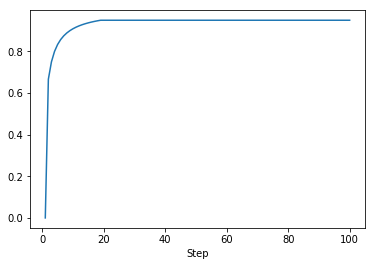

In [726]:
a_df.groupby(level=['Step']).mean()['informational_currency'].plot()

In [660]:
mp = model.blockchain.mempool[model.blockchain.mempool['mined'] == False].sort_values(by=['gas_spend']).reset_index()

In [662]:
mp['cum_gas'] = mp['gas_spend'].cumsum()

In [664]:
tx_mined = mp[0 : mp[mp['cum_gas'] > model.blockchain.block_gas_limit].index[0]]


In [665]:
tx_mined

index  block_mined block_submitted end_sync from_address gas_price  \
0     491          NaN              24       24            5        20   
1    1923          NaN              96       96           18        20   
2    1924          NaN              96       96           15        20   
3    1935          NaN              96       96           11        20   
4    1936          NaN              96       96           20        20   
5    1937          NaN              96       96            7        20   
6    1938          NaN              96       96            3        20   
7    2819          NaN             140      140           13        20   
8    2820          NaN             141      141            2        20   
9    2821          NaN             141      141           17        20   
10   2822          NaN             141      141           21        20   

    gas_spend  mined nonce  num_bytes start_sync tx_id    cum_gas  
0    800000.0  False    25       64.0         23   491   800000.0  
1    800000.0  False    97       64.0         95  1923  1600000.0  
2    800000.0  False    97       64.0         95  1924  2400000.0  
3    800000.0  False    97       64.0         95  1935  3200000.0  
4    800000.0  False    97       64.0         95  1936  4000000.0  
5    800000.0  False    97       64.0         95  1937  4800000.0  
6    800000.0  False    97       64.0         95  1938  5600000.0  
7    800000.0  False   141       64.0        139  2819  6400000.0  
8    800000.0  False   142       64.0        140  2820  7200000.0  
9    800000.0  False   142       64.0        140  2821  8000000.0  
10   800000.0  False   142       64.0        140  2822  8800000.0

In [654]:
model.blockchain.chain

2      3      4      5      6      7      8      9      10     11  \
0     True   True   True   True   True   True   True   True   True   True   
1     True   True   True   True   True   True   True   True   True   True   
2     True   True   True   True   True   True   True   True   True   True   
3     True   True   True   True   True   True   True   True   True   True   
4     True   True   True   True   True   True   True   True   True   True   
5     True   True   True   True   True   True   True   True   True   True   
6     True   True   True   True   True   True   True   True   True   True   
7     True   True   True   True   True   True   True   True   True   True   
8     True   True   True   True   True   True   True   True   True   True   
9     True   True   True   True   True   True   True   True   True   True   
10    True   True   True   True   True   True   True   True   True   True   
11    True   True   True   True   True   True   True   True   True   True   
12    True   True   True   True   True   True   True   True   True   True   
13    True   True   True   True   True   True   True   True   True   True   
14    True   True   True   True   True   True   True   True   True   True   
15    True   True   True   True   True   True   True   True   True   True   
16    True   True   True   True   True   True   True   True   True   True   
17    True   True   True   True   True   True   True   True   True   True   
18    True   True   True   True   True   True   True   True   True   True   
19    True   True   True   True   True   True   True   True   True   True   
20    True   True   True   True   True   True   True   True   True   True   
21    True   True   True   True   True   True   True   True   True   True   
22    True   True   True   True   True   True   True   True   True   True   
23    True   True   True   True   True   True   True   True   True   True   
24    True   True   True   True  False  False   True   True   True   True   
25    True   True   True   True   True   True   True   True   True   True   
26    True   True   True   True   True   True   True   True   True   True   
27    True  False   True   True   True   True   True   True   True   True   
28    True   True   True   True  False   True   True   True   True   True   
29    True   True   True  False  False   True   True   True   True   True   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
171  False  False  False  False  False  False  False  False  False  False   
172  False  False  False  False  False  False  False  False  False  False   
173  False  False  False  False  False  False  False  False  False  False   
174  False  False  False  False  False  False  False  False  False  False   
175  False  False  False  False  False  False  False  False  False  False   
176  False  False  False  False  False  False  False  False  False  False   
177  False  False  False  False  False  False  False  False  False  False   
178  False  False  False  False  False  False  False  False  False  False   
179  False  False  False  False  False  False  False  False  False  False   
180  False  False  False  False  False  False  False  False  False  False   
181  False  False  False  False  False  False  False  False  False  False   
182  False  False  False  False  False  False  False  False  False  False   
183  False  False  False  False  False  False  False  False  False  False   
184  False  False  False  False  False  False  False  False  False  False   
185  False  False  False  False  False  False  False  False  False  False   
186  False  False  False  False  False  False  False  False  False  False   
187  False  False  False  False  False  False  False  False  False  False   
188  False  False  False  False  False  False  False  False  False  False   
189  False  False  False  False  False  False  False  False  False  False   
190  False  False  False  False  False  False  False  False  False  False   
191 

In [491]:
fixed_params = {
    "blockchain_gas_price": 20,
    "block_gas_limit": 8000000,
    "gas_per_byte": 625,
    "gas_per_second": 75000000,
    "avg_block_time": 13,
    "verbose": False
}

variable_params = {
    "num_sensors": range(1,10,2),
    "battery_life": [1000, 10000, 100000],
    "record_freq": [1, 10, 100]
}

In [488]:
# Batch Run

batch_runner = BatchRunner(
    SensorBlockchainNetwork,
    variable_params,
    fixed_params,
    iterations = 1,
    max_steps = 100,
#     model_reporters = {"blockchain_size": lambda m: m.blockchain.chain_size}
)

In [489]:
batch_runner.run_all()

0it [00:00, ?it/s]

Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
1 instantiated and added to schedule.
Transmitting tx from 2
Transmitting tx from 2
Mining BLOCK NUMBER: 2
Mining 2 out of 2 unvalidated transactions.

Gas value: 1200000.0 

Mining tx id: 0
Mining tx id: 1


Transmitting tx from 2
Mining BLOCK NUMBER: 3
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 2


Transmitting tx from 2
Mining BLOCK NUMBER: 4
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 3


Transmitting tx from 2
Mining BLOCK NUMBER: 5
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 4


Transmitting tx from 2
Mining BLOCK NUMBER: 6
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 5


Transmitting tx from 2
Mining BLOCK NUMBER: 7
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 6


Transmitting tx from 2
Mining BLOCK NUMBER: 8
Mining 1 out of 1 unvali

1it [00:00,  2.50it/s]




Mining BLOCK NUMBER: 33
Empty mempool


Mining BLOCK NUMBER: 34
Empty mempool


Mining BLOCK NUMBER: 35
Empty mempool


Mining BLOCK NUMBER: 36
Empty mempool


Mining BLOCK NUMBER: 37
Empty mempool


Mining BLOCK NUMBER: 38
Empty mempool


Mining BLOCK NUMBER: 39
Empty mempool


Mining BLOCK NUMBER: 40
Empty mempool


Mining BLOCK NUMBER: 41
Empty mempool


Mining BLOCK NUMBER: 42
Empty mempool


Mining BLOCK NUMBER: 43
Empty mempool


Mining BLOCK NUMBER: 44
Empty mempool


Mining BLOCK NUMBER: 45
Empty mempool


Mining BLOCK NUMBER: 46
Empty mempool


Mining BLOCK NUMBER: 47
Empty mempool


Mining BLOCK NUMBER: 48
Empty mempool


Mining BLOCK NUMBER: 49
Empty mempool


Mining BLOCK NUMBER: 50
Empty mempool


Mining BLOCK NUMBER: 51
Empty mempool


Mining BLOCK NUMBER: 52
Empty mempool


Mining BLOCK NUMBER: 53
Empty mempool


Mining BLOCK NUMBER: 54
Empty mempool


Mining BLOCK NUMBER: 55
Empty mempool


Mining BLOCK NUMBER: 56
Empty mempool


Mining BLOCK NUMBER: 57
Empty mempool


Transmitting tx from 2
Mining BLOCK NUMBER: 48
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 47


Transmitting tx from 2
Mining BLOCK NUMBER: 49
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 48


Transmitting tx from 2
Mining BLOCK NUMBER: 50
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 49


Transmitting tx from 2
Mining BLOCK NUMBER: 51
Mining 1 out of 1 unvalidated transactions.

Gas value: 400000.0 

Mining tx id: 50


Transmitting tx from 2
Mining BLOCK NUMBER: 52
Mining 1 out of 1 unvalidated transactions.

Gas value: 400000.0 

Mining tx id: 51


Transmitting tx from 2
Mining BLOCK NUMBER: 53
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 52


Transmitting tx from 2
Mining BLOCK NUMBER: 54
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 53


Transmitting tx from 2
Mining BLOCK NUMBER: 55
Mining 1 out of 1 unvalidated transactions.

G

2it [00:01,  1.62it/s]


Transmitting tx from 2
Mining BLOCK NUMBER: 83
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 82


Transmitting tx from 2
Mining BLOCK NUMBER: 84
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 83


Transmitting tx from 2
Mining BLOCK NUMBER: 85
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 84


Transmitting tx from 2
Mining BLOCK NUMBER: 86
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 85


Transmitting tx from 2
Mining BLOCK NUMBER: 87
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 86


Transmitting tx from 2
Mining BLOCK NUMBER: 88
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 87


Transmitting tx from 2
Mining BLOCK NUMBER: 89
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 88


Transmitting tx from 2
Mining BLOCK NUMBER: 90
Mining 1 out of 1 unvalidated transactions.

Gas value: 

Mining BLOCK NUMBER: 57
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 56


Transmitting tx from 2
Mining BLOCK NUMBER: 58
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 57


Transmitting tx from 2
Mining BLOCK NUMBER: 59
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 58


Transmitting tx from 2
Mining BLOCK NUMBER: 60
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 59


Transmitting tx from 2
Mining BLOCK NUMBER: 61
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 60


Transmitting tx from 2
Mining BLOCK NUMBER: 62
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 61


Transmitting tx from 2
Mining BLOCK NUMBER: 63
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 62


Transmitting tx from 2
Mining BLOCK NUMBER: 64
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 63



3it [00:02,  1.28it/s]


Transmitting tx from 2
Mining BLOCK NUMBER: 96
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 95


Transmitting tx from 2
Mining BLOCK NUMBER: 97
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 96


Transmitting tx from 2
Mining BLOCK NUMBER: 98
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 97


Transmitting tx from 2
Mining BLOCK NUMBER: 99
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 98


Transmitting tx from 2
Mining BLOCK NUMBER: 100
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 99


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
1 instantiated and added to schedule.
Transmitting tx from 2
Transmitting tx from 2
Mining BLOCK NUMBER: 2
Mining 2 out of 2 unvalidated transactions.

Gas value: 1200000.0 

Mining tx id: 0
Mining tx id: 1


Transmitting tx from 2
Mining BLOCK NUMBER: 3
Mining 1 out of 1 unvalidated transac


Transmitting tx from 2
Mining BLOCK NUMBER: 68
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 67


Transmitting tx from 2
Mining BLOCK NUMBER: 69
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 68


Transmitting tx from 2
Mining BLOCK NUMBER: 70
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 69


Transmitting tx from 2
Mining BLOCK NUMBER: 71
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 70


Transmitting tx from 2
Mining BLOCK NUMBER: 72
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 71


Transmitting tx from 2
Mining BLOCK NUMBER: 73
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 72


Transmitting tx from 2
Mining BLOCK NUMBER: 74
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 73


Transmitting tx from 2
Mining BLOCK NUMBER: 75
Mining 1 out of 1 unv

4it [00:03,  1.12it/s]


Transmitting tx from 2
Mining BLOCK NUMBER: 86
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 85


Transmitting tx from 2
Mining BLOCK NUMBER: 87
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 86


Transmitting tx from 2
Mining BLOCK NUMBER: 88
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 87


Transmitting tx from 2
Mining BLOCK NUMBER: 89
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 88


Transmitting tx from 2
Mining BLOCK NUMBER: 90
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 89


Transmitting tx from 2
Mining BLOCK NUMBER: 91
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 90


Transmitting tx from 2
Mining BLOCK NUMBER: 92
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 91


Transmitting tx from 2
Mining BLOCK NUMBER: 93
Mining 1 out of 1 unv

Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 53


Transmitting tx from 2
Mining BLOCK NUMBER: 55
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 54


Transmitting tx from 2
Mining BLOCK NUMBER: 56
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 55


Transmitting tx from 2
Mining BLOCK NUMBER: 57
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 56


Transmitting tx from 2
Mining BLOCK NUMBER: 58
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 57


Transmitting tx from 2
Mining BLOCK NUMBER: 59
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 58


Transmitting tx from 2
Mining BLOCK NUMBER: 60
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 59


Transmitting tx from 2
Mining BLOCK NUMBER: 61
Mining 1 out of 1 unvalidated transactions.

Gas value: 400000.0 

Mining tx id: 60


Transmitting tx fr

5it [00:05,  1.01it/s]

 94
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 93


Transmitting tx from 2
Mining BLOCK NUMBER: 95
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 94


Transmitting tx from 2
Mining BLOCK NUMBER: 96
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 95


Transmitting tx from 2
Mining BLOCK NUMBER: 97
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 96


Transmitting tx from 2
Mining BLOCK NUMBER: 98
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 97


Transmitting tx from 2
Mining BLOCK NUMBER: 99
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 98


Transmitting tx from 2
Mining BLOCK NUMBER: 100
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 99


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
1 instantiated and added to schedule.
Transmitting tx from 2
Transmitting tx fro

Mining BLOCK NUMBER: 70
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 69


Transmitting tx from 2
Mining BLOCK NUMBER: 71
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 70


Transmitting tx from 2
Mining BLOCK NUMBER: 72
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 71


Transmitting tx from 2
Mining BLOCK NUMBER: 73
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 72


Transmitting tx from 2
Mining BLOCK NUMBER: 74
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 73


Transmitting tx from 2
Mining BLOCK NUMBER: 75
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 74


Transmitting tx from 2
Mining BLOCK NUMBER: 76
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 75


Transmitting tx from 2
Mining BLOCK NUMBER: 77
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 76



6it [00:06,  1.04s/it]

 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 89


Transmitting tx from 2
Mining BLOCK NUMBER: 91
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 90


Transmitting tx from 2
Mining BLOCK NUMBER: 92
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 91


Transmitting tx from 2
Mining BLOCK NUMBER: 93
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 92


Transmitting tx from 2
Mining BLOCK NUMBER: 94
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 93


Transmitting tx from 2
Mining BLOCK NUMBER: 95
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 94


Transmitting tx from 2
Mining BLOCK NUMBER: 96
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 95


Transmitting tx from 2
Mining BLOCK NUMBER: 97
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 96


Transmitting tx from 2
Mining

Mining BLOCK NUMBER: 59
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 58


Transmitting tx from 2
Mining BLOCK NUMBER: 60
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 59


Transmitting tx from 2
Mining BLOCK NUMBER: 61
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 60


Transmitting tx from 2
Mining BLOCK NUMBER: 62
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 61


Transmitting tx from 2
Mining BLOCK NUMBER: 63
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 62


Transmitting tx from 2
Mining BLOCK NUMBER: 64
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 63


Transmitting tx from 2
Mining BLOCK NUMBER: 65
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 64


Transmitting tx from 2
Mining BLOCK NUMBER: 66
Mining 1 out of 1 unvalidated transactions.



7it [00:07,  1.10s/it]

 93
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 92


Transmitting tx from 2
Mining BLOCK NUMBER: 94
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 93


Transmitting tx from 2
Mining BLOCK NUMBER: 95
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 94


Transmitting tx from 2
Mining BLOCK NUMBER: 96
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 95


Transmitting tx from 2
Mining BLOCK NUMBER: 97
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 96


Transmitting tx from 2
Mining BLOCK NUMBER: 98
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 97


Transmitting tx from 2
Mining BLOCK NUMBER: 99
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0 

Mining tx id: 98


Transmitting tx from 2
Mining BLOCK NUMBER: 100
Mining 1 out of 1 unvalidated transactions.

Gas value: 800000.0

Mining BLOCK NUMBER: 73
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 72


Transmitting tx from 2
Mining BLOCK NUMBER: 74
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 73


Transmitting tx from 2
Mining BLOCK NUMBER: 75
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 74


Transmitting tx from 2
Mining BLOCK NUMBER: 76
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 75


Transmitting tx from 2
Mining BLOCK NUMBER: 77
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 76


Transmitting tx from 2
Mining BLOCK NUMBER: 78
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 77


Transmitting tx from 2
Mining BLOCK NUMBER: 79
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 78


Transmitting tx from 2
Mining BLOCK NUMBER: 80
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 79



8it [00:08,  1.11s/it]

Mining 1 out of 1 unvalidated transactions.

Gas value: 400000.0 

Mining tx id: 91


Transmitting tx from 2
Mining BLOCK NUMBER: 93
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 92


Transmitting tx from 2
Mining BLOCK NUMBER: 94
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 93


Transmitting tx from 2
Mining BLOCK NUMBER: 95
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 94


Transmitting tx from 2
Mining BLOCK NUMBER: 96
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 95


Transmitting tx from 2
Mining BLOCK NUMBER: 97
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 96


Transmitting tx from 2
Mining BLOCK NUMBER: 98
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 97


Transmitting tx from 2
Mining BLOCK NUMBER: 99
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 98


Transmitting tx fr

Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 66


Transmitting tx from 2
Mining BLOCK NUMBER: 68
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 67


Transmitting tx from 2
Mining BLOCK NUMBER: 69
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 68


Transmitting tx from 2
Mining BLOCK NUMBER: 70
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 69


Transmitting tx from 2
Mining BLOCK NUMBER: 71
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 70


Transmitting tx from 2
Mining BLOCK NUMBER: 72
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 71


Transmitting tx from 2
Mining BLOCK NUMBER: 73
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 72


Transmitting tx from 2
Mining BLOCK NUMBER: 74
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 73


Transmitting tx from 2


9it [00:09,  1.11s/it]


Transmitting tx from 2
Mining BLOCK NUMBER: 86
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 85


Transmitting tx from 2
Mining BLOCK NUMBER: 87
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 86


Transmitting tx from 2
Mining BLOCK NUMBER: 88
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 87


Transmitting tx from 2
Mining BLOCK NUMBER: 89
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 88


Transmitting tx from 2
Mining BLOCK NUMBER: 90
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 89


Transmitting tx from 2
Mining BLOCK NUMBER: 91
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 90


Transmitting tx from 2
Mining BLOCK NUMBER: 92
Mining 1 out of 1 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 91


Transmitting tx from 2
Mining BLOCK NUMBER: 93
Mining 1 out of 1 unvalidated transactions.

Gas value: 

10it [00:10,  1.04it/s]




Mining BLOCK NUMBER: 51
Empty mempool


Mining BLOCK NUMBER: 52
Empty mempool


Mining BLOCK NUMBER: 53
Empty mempool


Mining BLOCK NUMBER: 54
Empty mempool


Mining BLOCK NUMBER: 55
Empty mempool


Mining BLOCK NUMBER: 56
Empty mempool


Mining BLOCK NUMBER: 57
Empty mempool


Mining BLOCK NUMBER: 58
Empty mempool


Mining BLOCK NUMBER: 59
Empty mempool


Mining BLOCK NUMBER: 60
Empty mempool


Mining BLOCK NUMBER: 61
Empty mempool


Mining BLOCK NUMBER: 62
Empty mempool


Mining BLOCK NUMBER: 63
Empty mempool


Mining BLOCK NUMBER: 64
Empty mempool


Mining BLOCK NUMBER: 65
Empty mempool


Mining BLOCK NUMBER: 66
Empty mempool


Mining BLOCK NUMBER: 67
Empty mempool


Mining BLOCK NUMBER: 68
Empty mempool


Mining BLOCK NUMBER: 69
Empty mempool


Mining BLOCK NUMBER: 70
Empty mempool


Mining BLOCK NUMBER: 71
Empty mempool


Mining BLOCK NUMBER: 72
Empty mempool


Mining BLOCK NUMBER: 73
Empty mempool


Mining BLOCK NUMBER: 74
Empty mempool


Mining BLOCK NUMBER: 75
Empty mempool

Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 96
Mining tx id: 97
Mining tx id: 98


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 34
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 99
Mining tx id: 100
Mining tx id: 101


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 35
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 102
Mining tx id: 103
Mining tx id: 104


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 36
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 105
Mining tx id: 106
Mining tx id: 107


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 37
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 108
Mining tx id: 109
Mining tx id: 110


Transmitting tx from 2
Transmitting tx fro

Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 72
Mining 3 out of 3 unvalidated transactions.

Gas value: 1200000.0 

Mining tx id: 213
Mining tx id: 214
Mining tx id: 215


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 73
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 216
Mining tx id: 217
Mining tx id: 218


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 74
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 219
Mining tx id: 220
Mining tx id: 221


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 75
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 222
Mining tx id: 223
Mining tx id: 224


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 76
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 225


11it [00:13,  1.51s/it]

 2
Transmitting tx from 3
Mining BLOCK NUMBER: 94
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 279
Mining tx id: 280
Mining tx id: 281


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 95
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 282
Mining tx id: 283
Mining tx id: 284


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 96
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 285
Mining tx id: 286
Mining tx id: 287


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 97
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 288
Mining tx id: 289
Mining tx id: 290


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 98
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 291
Mining tx id: 292
Mining t


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 36
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 105
Mining tx id: 106
Mining tx id: 107


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 37
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 108
Mining tx id: 109
Mining tx id: 110


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 38
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 111
Mining tx id: 112
Mining tx id: 113


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 39
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 114
Mining tx id: 115
Mining tx id: 116


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 40
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 



Mining tx id: 223
Mining tx id: 224


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 76
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 225
Mining tx id: 226
Mining tx id: 227


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 77
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 228
Mining tx id: 229
Mining tx id: 230


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 78
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 231
Mining tx id: 232
Mining tx id: 233


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 79
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 234
Mining tx id: 235
Mining tx id: 236


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 80
Mining 3 out of 3 unvalid

12it [00:15,  1.85s/it]

Mining tx id: 289
Mining tx id: 290


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 98
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 291
Mining tx id: 292
Mining tx id: 293


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 99
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 294
Mining tx id: 295
Mining tx id: 296


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 100
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 297
Mining tx id: 298
Mining tx id: 299


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
3 instantiated and added to schedule.
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 2
Mining 6 



Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 42
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 123
Mining tx id: 124
Mining tx id: 125


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 43
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 126
Mining tx id: 127
Mining tx id: 128


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 44
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 129
Mining tx id: 130
Mining tx id: 131


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 45
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 132
Mining tx id: 133
Mining tx id: 134


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 46
Mining 3 out of 3 unvalidated transac

Mining tx id: 254


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 86
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 255
Mining tx id: 256
Mining tx id: 257


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 87
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 258
Mining tx id: 259
Mining tx id: 260


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 88
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 261
Mining tx id: 262
Mining tx id: 263


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 89
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 264
Mining tx id: 265
Mining tx id: 266


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 90
Mining 3 out of 3 u

13it [00:18,  2.17s/it]

Mining tx id: 278


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 94
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 279
Mining tx id: 280
Mining tx id: 281


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 95
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 282
Mining tx id: 283
Mining tx id: 284


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 96
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 285
Mining tx id: 286
Mining tx id: 287


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 97
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 288
Mining tx id: 289
Mining tx id: 290


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 98
Mining 3 out of 3 u

Mining BLOCK NUMBER: 37
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 108
Mining tx id: 109
Mining tx id: 110


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 38
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 111
Mining tx id: 112
Mining tx id: 113


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 39
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 114
Mining tx id: 115
Mining tx id: 116


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 40
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 117
Mining tx id: 118
Mining tx id: 119


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 41
Mining 3 out of 3 unvalidated transactions.

Gas value: 1200000.0 

Mining tx id: 120
Mining tx id: 121
Mining tx id: 122


Transmit


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 79
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 234
Mining tx id: 235
Mining tx id: 236


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 80
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 237
Mining tx id: 238
Mining tx id: 239


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 81
Mining 3 out of 3 unvalidated transactions.

Gas value: 1200000.0 

Mining tx id: 240
Mining tx id: 241
Mining tx id: 242


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 82
Mining 3 out of 3 unvalidated transactions.

Gas value: 1200000.0 

Mining tx id: 243
Mining tx id: 244
Mining tx id: 245


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 83
Mining 3 out of 3 unvalidated transactions.

Gas v

14it [00:21,  2.27s/it]

Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 282
Mining tx id: 283
Mining tx id: 284


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 96
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 285
Mining tx id: 286
Mining tx id: 287


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 97
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 288
Mining tx id: 289
Mining tx id: 290


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 98
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 291
Mining tx id: 292
Mining tx id: 293


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 99
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 294
Mining tx id: 295
Mining tx id: 296


Transmitting tx from 2
Transmitting tx

Transmitting tx from 4
Mining BLOCK NUMBER: 39
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 114
Mining tx id: 115
Mining tx id: 116


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 40
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 117
Mining tx id: 118
Mining tx id: 119


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 41
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 120
Mining tx id: 121
Mining tx id: 122


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 42
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 123
Mining tx id: 124
Mining tx id: 125


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 43
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 126
Mining tx id: 127
Mining tx i

Transmitting tx from 3
Mining BLOCK NUMBER: 86
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 255
Mining tx id: 256
Mining tx id: 257


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 87
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 258
Mining tx id: 259
Mining tx id: 260


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 88
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 261
Mining tx id: 262
Mining tx id: 263


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 89
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 264
Mining tx id: 265
Mining tx id: 266


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 90
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 267
Mining tx id: 268
Mining tx i

15it [00:23,  2.37s/it]

 94
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 279
Mining tx id: 280
Mining tx id: 281


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 95
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 282
Mining tx id: 283
Mining tx id: 284


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 96
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 285
Mining tx id: 286
Mining tx id: 287


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 97
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 288
Mining tx id: 289
Mining tx id: 290


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 98
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 291
Mining tx id: 292
Mining tx id: 293


Transmitting tx from 4
Transmittin

Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 40
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 117
Mining tx id: 118
Mining tx id: 119


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 41
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 120
Mining tx id: 121
Mining tx id: 122


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 42
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 123
Mining tx id: 124
Mining tx id: 125


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 43
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 126
Mining tx id: 127
Mining tx id: 128


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 44
Mining 3 out of 3 unvalidated transactions.

Gas value: 240000

Transmitting tx from 4
Mining BLOCK NUMBER: 83
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 246
Mining tx id: 247
Mining tx id: 248


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 84
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 249
Mining tx id: 250
Mining tx id: 251


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 85
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 252
Mining tx id: 253
Mining tx id: 254


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 86
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 255
Mining tx id: 256
Mining tx id: 257


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 87
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 258

16it [00:26,  2.40s/it]



Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 100
Mining 3 out of 3 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 297
Mining tx id: 298
Mining tx id: 299


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
3 instantiated and added to schedule.
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 2
Mining 6 out of 6 unvalidated transactions.

Gas value: 2400000.0 

Mining tx id: 0
Mining tx id: 1
Mining tx id: 2
Mining tx id: 3
Mining tx id: 4
Mining tx id: 5


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 3
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 6
Mining tx id: 7
Mining tx id: 8


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 4

Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 45
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 132
Mining tx id: 133
Mining tx id: 134


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 46
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 135
Mining tx id: 136
Mining tx id: 137


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 47
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 138
Mining tx id: 139
Mining tx id: 140


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 48
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 141
Mining tx id: 142
Mining tx id: 143


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 49
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 144
Mining

Mining tx id: 256
Mining tx id: 257


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 87
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 258
Mining tx id: 259
Mining tx id: 260


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 88
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 261
Mining tx id: 262
Mining tx id: 263


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 89
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 264
Mining tx id: 265
Mining tx id: 266


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 90
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 267
Mining tx id: 268
Mining tx id: 269


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 91
Mining 3 out of 3 unvalid

17it [00:28,  2.42s/it]

 3
Mining BLOCK NUMBER: 95
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 282
Mining tx id: 283
Mining tx id: 284


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 96
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 285
Mining tx id: 286
Mining tx id: 287


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 97
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 288
Mining tx id: 289
Mining tx id: 290


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 98
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 291
Mining tx id: 292
Mining tx id: 293


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 99
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 294
Mining tx id: 295
Mining tx id: 296


Transmittin

Mining tx id: 118
Mining tx id: 119


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 41
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 120
Mining tx id: 121
Mining tx id: 122


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 42
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 123
Mining tx id: 124
Mining tx id: 125


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 43
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 126
Mining tx id: 127
Mining tx id: 128


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 44
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 129
Mining tx id: 130
Mining tx id: 131


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 45
Mining 3 out of 3 unvalid

Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 243
Mining tx id: 244
Mining tx id: 245


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 83
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 246
Mining tx id: 247
Mining tx id: 248


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 84
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 249
Mining tx id: 250
Mining tx id: 251


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 85
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 252
Mining tx id: 253
Mining tx id: 254


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 86
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 255
Mining tx id: 256
Mining tx id: 257


Transmitting tx from 2
Transmitting tx

18it [00:31,  2.43s/it]

0.0 

Mining tx id: 294
Mining tx id: 295
Mining tx id: 296


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 100
Mining 3 out of 3 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 297
Mining tx id: 298
Mining tx id: 299


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
5 instantiated and added to schedule.
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 2
Mining 10 out of 10 unvalidated transactions.

Gas value: 6000000.0 

Mining tx id: 0
Mining tx id: 1
Mining tx id: 2
Mining tx id: 3
Mining tx id: 4
Mining tx id: 5
Mining tx id: 6
Mining tx id: 7
Mining tx id: 8
Mining tx id: 9


Transmitting tx from 4
Transm

19it [00:31,  1.95s/it]

Empty mempool


Mining BLOCK NUMBER: 98
Empty mempool


Mining BLOCK NUMBER: 99
Empty mempool


Mining BLOCK NUMBER: 100
Empty mempool


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
5 instantiated and added to schedule.
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 2
Mining 10 out of 10 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 0
Mining tx id: 1
Mining tx id: 2
Mining tx id: 3
Mining tx id: 4
Mining tx id: 5
Mining tx id: 6
Mining tx id: 7
Mining tx id: 8
Mining tx id: 9


Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 3
Mining 5 out of 5 unvalidate

Mining BLOCK NUMBER: 31
Mining 5 out of 5 unvalidated transactions.

Gas value: 2000000.0 

Mining tx id: 150
Mining tx id: 151
Mining tx id: 152
Mining tx id: 153
Mining tx id: 154


Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 32
Mining 5 out of 5 unvalidated transactions.

Gas value: 2000000.0 

Mining tx id: 155
Mining tx id: 156
Mining tx id: 157
Mining tx id: 158
Mining tx id: 159


Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 33
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 160
Mining tx id: 161
Mining tx id: 162
Mining tx id: 163
Mining tx id: 164


Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 2
Mining BLOCK NUMBER: 34
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 165
Minin

Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 6
Mining BLOCK NUMBER: 64
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 315
Mining tx id: 316
Mining tx id: 317
Mining tx id: 318
Mining tx id: 319


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Mining BLOCK NUMBER: 65
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 320
Mining tx id: 321
Mining tx id: 322
Mining tx id: 323
Mining tx id: 324


Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 6
Mining BLOCK NUMBER: 66
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 325
Mining tx id: 326
Mining tx id: 327
Mining tx id: 328
Mining tx id: 329


Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 3
Mining BLOCK NUMBER: 67
Minin

20it [00:35,  2.51s/it]

Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 5
Mining BLOCK NUMBER: 96
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 475
Mining tx id: 476
Mining tx id: 477
Mining tx id: 478
Mining tx id: 479


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Mining BLOCK NUMBER: 97
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 480
Mining tx id: 481
Mining tx id: 482
Mining tx id: 483
Mining tx id: 484


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Mining BLOCK NUMBER: 98
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 485
Mining tx id: 486
Mining tx id: 487
Mining tx id: 488
Mining tx id: 489


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 2
Mining BLOCK NUMBER: 99
Mining 5 out of 5 unvalidate

Mining tx id: 117
Mining tx id: 118
Mining tx id: 119


Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 5
Mining BLOCK NUMBER: 25
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 120
Mining tx id: 121
Mining tx id: 122
Mining tx id: 123
Mining tx id: 124


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 6
Mining BLOCK NUMBER: 26
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 125
Mining tx id: 126
Mining tx id: 127
Mining tx id: 128
Mining tx id: 129


Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 27
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 130
Mining tx id: 131
Mining tx id: 132
Mining tx id: 133
Mining tx id: 134


Transmitting tx from 3
Transmitting tx from 5
Transmitting tx fro


Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 2
Mining BLOCK NUMBER: 58
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 285
Mining tx id: 286
Mining tx id: 287
Mining tx id: 288
Mining tx id: 289


Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 5
Mining BLOCK NUMBER: 59
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 290
Mining tx id: 291
Mining tx id: 292
Mining tx id: 293
Mining tx id: 294


Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Mining BLOCK NUMBER: 60
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 295
Mining tx id: 296
Mining tx id: 297
Mining tx id: 298
Mining tx id: 299


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 2
Minin

Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 445
Mining tx id: 446
Mining tx id: 447
Mining tx id: 448
Mining tx id: 449


Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 91
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 450
Mining tx id: 451
Mining tx id: 452
Mining tx id: 453
Mining tx id: 454


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 2
Mining BLOCK NUMBER: 92
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 455
Mining tx id: 456
Mining tx id: 457
Mining tx id: 458
Mining tx id: 459


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 4
Mining BLOCK NUMBER: 93
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 460
Mining tx id: 461
Mining tx id: 462
Minin

21it [00:39,  2.90s/it]


Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 96
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 475
Mining tx id: 476
Mining tx id: 477
Mining tx id: 478
Mining tx id: 479


Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 97
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 480
Mining tx id: 481
Mining tx id: 482
Mining tx id: 483
Mining tx id: 484


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Mining BLOCK NUMBER: 98
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 485
Mining tx id: 486
Mining tx id: 487
Mining tx id: 488
Mining tx id: 489


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 6
Minin

Mining tx id: 121
Mining tx id: 122
Mining tx id: 123
Mining tx id: 124


Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 26
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 125
Mining tx id: 126
Mining tx id: 127
Mining tx id: 128
Mining tx id: 129


Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 27
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 130
Mining tx id: 131
Mining tx id: 132
Mining tx id: 133
Mining tx id: 134


Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 28
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 135
Mining tx id: 136
Mining tx id: 137
Mining tx id: 138
Mining tx id: 139


Transmitting tx from 5
Transm

Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 3
Mining BLOCK NUMBER: 54
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 265
Mining tx id: 266
Mining tx id: 267
Mining tx id: 268
Mining tx id: 269


Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 4
Mining BLOCK NUMBER: 55
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 270
Mining tx id: 271
Mining tx id: 272
Mining tx id: 273
Mining tx id: 274


Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 56
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 275
Mining tx id: 276
Mining tx id: 277
Mining tx id: 278
Mining tx id: 279


Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 57
Mining 5 o

Transmitting tx from 5
Mining BLOCK NUMBER: 86
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 425
Mining tx id: 426
Mining tx id: 427
Mining tx id: 428
Mining tx id: 429


Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 2
Mining BLOCK NUMBER: 87
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 430
Mining tx id: 431
Mining tx id: 432
Mining tx id: 433
Mining tx id: 434


Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 6
Mining BLOCK NUMBER: 88
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 435
Mining tx id: 436
Mining tx id: 437
Mining tx id: 438
Mining tx id: 439


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 6
Mining BLOCK NUMBER: 89
Mining 5 out of 5 unvalidated transactions.

Gas value: 

22it [00:43,  3.17s/it]

Mining BLOCK NUMBER: 97
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 480
Mining tx id: 481
Mining tx id: 482
Mining tx id: 483
Mining tx id: 484


Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 4
Mining BLOCK NUMBER: 98
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 485
Mining tx id: 486
Mining tx id: 487
Mining tx id: 488
Mining tx id: 489


Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 99
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 490
Mining tx id: 491
Mining tx id: 492
Mining tx id: 493
Mining tx id: 494


Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 6
Mining BLOCK NUMBER: 100
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx 

Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 27
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 130
Mining tx id: 131
Mining tx id: 132
Mining tx id: 133
Mining tx id: 134


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 6
Mining BLOCK NUMBER: 28
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 135
Mining tx id: 136
Mining tx id: 137
Mining tx id: 138
Mining tx id: 139


Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 4
Mining BLOCK NUMBER: 29
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 140
Mining tx id: 141
Mining tx id: 142
Mining tx id: 143
Mining tx id: 144


Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 30
Mining 5 out of 5 unvalidate

Transmitting tx from 2
Transmitting tx from 5
Mining BLOCK NUMBER: 60
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 295
Mining tx id: 296
Mining tx id: 297
Mining tx id: 298
Mining tx id: 299


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 3
Mining BLOCK NUMBER: 61
Mining 5 out of 5 unvalidated transactions.

Gas value: 2000000.0 

Mining tx id: 300
Mining tx id: 301
Mining tx id: 302
Mining tx id: 303
Mining tx id: 304


Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 62
Mining 5 out of 5 unvalidated transactions.

Gas value: 2000000.0 

Mining tx id: 305
Mining tx id: 306
Mining tx id: 307
Mining tx id: 308
Mining tx id: 309


Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 63
Mining 5 out of 5 unvalidated transacti



Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 5
Mining BLOCK NUMBER: 93
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 460
Mining tx id: 461
Mining tx id: 462
Mining tx id: 463
Mining tx id: 464


Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 94
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 465
Mining tx id: 466
Mining tx id: 467
Mining tx id: 468
Mining tx id: 469


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 6
Mining BLOCK NUMBER: 95
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 470
Mining tx id: 471
Mining tx id: 472
Mining tx id: 473
Mining tx id: 474


Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 2
Mini

23it [00:47,  3.37s/it]


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Mining BLOCK NUMBER: 98
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 485
Mining tx id: 486
Mining tx id: 487
Mining tx id: 488
Mining tx id: 489


Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 2
Mining BLOCK NUMBER: 99
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 490
Mining tx id: 491
Mining tx id: 492
Mining tx id: 493
Mining tx id: 494


Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 2
Mining BLOCK NUMBER: 100
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 495
Mining tx id: 496
Mining tx id: 497
Mining tx id: 498
Mining tx id: 499


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4

Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 125
Mining tx id: 126
Mining tx id: 127
Mining tx id: 128
Mining tx id: 129


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 6
Mining BLOCK NUMBER: 27
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 130
Mining tx id: 131
Mining tx id: 132
Mining tx id: 133
Mining tx id: 134


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 2
Mining BLOCK NUMBER: 28
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 135
Mining tx id: 136
Mining tx id: 137
Mining tx id: 138
Mining tx id: 139


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 6
Mining BLOCK NUMBER: 29
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 140
Mining tx id: 141
Mining tx id: 142
Minin

Transmitting tx from 5
Transmitting tx from 3
Mining BLOCK NUMBER: 59
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 290
Mining tx id: 291
Mining tx id: 292
Mining tx id: 293
Mining tx id: 294


Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 4
Mining BLOCK NUMBER: 60
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 295
Mining tx id: 296
Mining tx id: 297
Mining tx id: 298
Mining tx id: 299


Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 6
Mining BLOCK NUMBER: 61
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 300
Mining tx id: 301
Mining tx id: 302
Mining tx id: 303
Mining tx id: 304


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 3
Mining BLOCK NUMBER: 62
Mining 5 out of 5 unvalidated transactions.

Gas va

Transmitting tx from 6
Mining BLOCK NUMBER: 92
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 455
Mining tx id: 456
Mining tx id: 457
Mining tx id: 458
Mining tx id: 459


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 3
Mining BLOCK NUMBER: 93
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 460
Mining tx id: 461
Mining tx id: 462
Mining tx id: 463
Mining tx id: 464


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 6
Mining BLOCK NUMBER: 94
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 465
Mining tx id: 466
Mining tx id: 467
Mining tx id: 468
Mining tx id: 469


Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 95
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id

24it [00:51,  3.51s/it]

Mining tx id: 482
Mining tx id: 483
Mining tx id: 484


Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 98
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 485
Mining tx id: 486
Mining tx id: 487
Mining tx id: 488
Mining tx id: 489


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 5
Mining BLOCK NUMBER: 99
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 490
Mining tx id: 491
Mining tx id: 492
Mining tx id: 493
Mining tx id: 494


Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 2
Mining BLOCK NUMBER: 100
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 495
Mining tx id: 496
Mining tx id: 497
Mining tx id: 498
Mining tx id: 499


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 

Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 5
Mining BLOCK NUMBER: 28
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 135
Mining tx id: 136
Mining tx id: 137
Mining tx id: 138
Mining tx id: 139


Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 29
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 140
Mining tx id: 141
Mining tx id: 142
Mining tx id: 143
Mining tx id: 144


Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 3
Mining BLOCK NUMBER: 30
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 145
Mining tx id: 146
Mining tx id: 147
Mining tx id: 148
Mining tx id: 149


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 6
Mining BLOC


Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 56
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 275
Mining tx id: 276
Mining tx id: 277
Mining tx id: 278
Mining tx id: 279


Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 3
Mining BLOCK NUMBER: 57
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 280
Mining tx id: 281
Mining tx id: 282
Mining tx id: 283
Mining tx id: 284


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 6
Mining BLOCK NUMBER: 58
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 285
Mining tx id: 286
Mining tx id: 287
Mining tx id: 288
Mining tx id: 289


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 6
Transmitti

Mining tx id: 433
Mining tx id: 434


Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 4
Mining BLOCK NUMBER: 88
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 435
Mining tx id: 436
Mining tx id: 437
Mining tx id: 438
Mining tx id: 439


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 5
Mining BLOCK NUMBER: 89
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 440
Mining tx id: 441
Mining tx id: 442
Mining tx id: 443
Mining tx id: 444


Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 90
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 445
Mining tx id: 446
Mining tx id: 447
Mining tx id: 448
Mining tx id: 449


Transmitting tx from 6
Transmitting tx from 3
Transmitting tx fro

25it [00:54,  3.60s/it]


Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 6
Mining BLOCK NUMBER: 99
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 490
Mining tx id: 491
Mining tx id: 492
Mining tx id: 493
Mining tx id: 494


Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 5
Mining BLOCK NUMBER: 100
Mining 5 out of 5 unvalidated transactions.

Gas value: 4000000.0 

Mining tx id: 495
Mining tx id: 496
Mining tx id: 497
Mining tx id: 498
Mining tx id: 499


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
5 instantiated and added to schedule.
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 4
Tran

Mining tx id: 131
Mining tx id: 132
Mining tx id: 133
Mining tx id: 134


Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 6
Mining BLOCK NUMBER: 28
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 135
Mining tx id: 136
Mining tx id: 137
Mining tx id: 138
Mining tx id: 139


Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 29
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 140
Mining tx id: 141
Mining tx id: 142
Mining tx id: 143
Mining tx id: 144


Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 2
Mining BLOCK NUMBER: 30
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 145
Mining tx id: 146
Mining tx id: 147
Mining tx id: 148
Mining tx id: 149


Transmitting tx from 6
Transmitting tx from 5
T

Mining tx id: 299


Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 61
Mining 5 out of 5 unvalidated transactions.

Gas value: 2000000.0 

Mining tx id: 300
Mining tx id: 301
Mining tx id: 302
Mining tx id: 303
Mining tx id: 304


Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 4
Mining BLOCK NUMBER: 62
Mining 5 out of 5 unvalidated transactions.

Gas value: 2000000.0 

Mining tx id: 305
Mining tx id: 306
Mining tx id: 307
Mining tx id: 308
Mining tx id: 309


Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 63
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 310
Mining tx id: 311
Mining tx id: 312
Mining tx id: 313
Mining tx id: 314


Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from

Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 3
Mining BLOCK NUMBER: 94
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 465
Mining tx id: 466
Mining tx id: 467
Mining tx id: 468
Mining tx id: 469


Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 4
Mining BLOCK NUMBER: 95
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 470
Mining tx id: 471
Mining tx id: 472
Mining tx id: 473
Mining tx id: 474


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 5
Mining BLOCK NUMBER: 96
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 475
Mining tx id: 476
Mining tx id: 477
Mining tx id: 478
Mining tx id: 479


Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Mining BLOCK NUMBER: 97
Minin

26it [00:58,  3.66s/it]

Transmitting tx from 6
Mining BLOCK NUMBER: 99
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 490
Mining tx id: 491
Mining tx id: 492
Mining tx id: 493
Mining tx id: 494


Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 5
Mining BLOCK NUMBER: 100
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 495
Mining tx id: 496
Mining tx id: 497
Mining tx id: 498
Mining tx id: 499


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
5 instantiated and added to schedule.
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 2
Mining BLOCK NUMBER: 2
Mining 10 out of 10 unvalidated transact

Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 6
Mining BLOCK NUMBER: 29
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 140
Mining tx id: 141
Mining tx id: 142
Mining tx id: 143
Mining tx id: 144


Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 30
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 145
Mining tx id: 146
Mining tx id: 147
Mining tx id: 148
Mining tx id: 149


Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 31
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 150
Mining tx id: 151
Mining tx id: 152
Mining tx id: 153
Mining tx id: 154


Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 6
Mining BLOCK NUMBER: 32
Minin

Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 300
Mining tx id: 301
Mining tx id: 302
Mining tx id: 303
Mining tx id: 304


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Mining BLOCK NUMBER: 62
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 305
Mining tx id: 306
Mining tx id: 307
Mining tx id: 308
Mining tx id: 309


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 2
Mining BLOCK NUMBER: 63
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 310
Mining tx id: 311
Mining tx id: 312
Mining tx id: 313
Mining tx id: 314


Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 4
Mining BLOCK NUMBER: 64
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 315
Mining tx id: 316
Mining tx id: 317
Minin

Transmitting tx from 4
Mining BLOCK NUMBER: 94
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 465
Mining tx id: 466
Mining tx id: 467
Mining tx id: 468
Mining tx id: 469


Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 95
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 470
Mining tx id: 471
Mining tx id: 472
Mining tx id: 473
Mining tx id: 474


Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 6
Mining BLOCK NUMBER: 96
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 475
Mining tx id: 476
Mining tx id: 477
Mining tx id: 478
Mining tx id: 479


Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 3
Mining BLOCK NUMBER: 97
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id

27it [01:02,  3.71s/it]

 5
Mining BLOCK NUMBER: 100
Mining 5 out of 5 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 495
Mining tx id: 496
Mining tx id: 497
Mining tx id: 498
Mining tx id: 499


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
Creating Sensor agent ID 7
Creating Sensor agent ID 8
7 instantiated and added to schedule.
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 4
Mining BLOCK NUMBER: 2
Mining 13 out of 14 unvalidated transactions.

Gas value: 7600000.0 

Mining tx id: 0
Mining tx id: 1
Mining tx id: 2
Mining tx id: 3
Mining tx id: 4
Mining tx id: 5
Mining tx id: 6
Mining tx id: 7
Mining tx

28it [01:03,  2.91s/it]

Empty mempool


Mining BLOCK NUMBER: 95
Empty mempool


Mining BLOCK NUMBER: 96
Empty mempool


Mining BLOCK NUMBER: 97
Empty mempool


Mining BLOCK NUMBER: 98
Empty mempool


Mining BLOCK NUMBER: 99
Empty mempool


Mining BLOCK NUMBER: 100
Empty mempool


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
Creating Sensor agent ID 7
Creating Sensor agent ID 8
7 instantiated and added to schedule.
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 7
Mining BLOCK NUMBER: 2
Mining 14 out of 14 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 0
Mining tx id: 1
Mining tx id: 2
Mining tx id: 

Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 8
Mining BLOCK NUMBER: 22
Mining 7 out of 7 unvalidated transactions.

Gas value: 2800000.0 

Mining tx id: 147
Mining tx id: 148
Mining tx id: 149
Mining tx id: 150
Mining tx id: 151
Mining tx id: 152
Mining tx id: 153


Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 2
Mining BLOCK NUMBER: 23
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 154
Mining tx id: 155
Mining tx id: 156
Mining tx id: 157
Mining tx id: 158
Mining tx id: 159
Mining tx id: 160


Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 8
Mining BLOCK NUMBER: 24
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 161
Mi

Transmitting tx from 6
Transmitting tx from 2
Mining BLOCK NUMBER: 45
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 308
Mining tx id: 309
Mining tx id: 310
Mining tx id: 311
Mining tx id: 312
Mining tx id: 313
Mining tx id: 314


Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 46
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 315
Mining tx id: 316
Mining tx id: 317
Mining tx id: 318
Mining tx id: 319
Mining tx id: 320
Mining tx id: 321


Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 47
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 322
Mining tx id: 323
Mining tx id: 324
Mining tx id: 325
Mining tx id: 326
Mining tx id: 327
Mining tx 


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 6
Mining BLOCK NUMBER: 69
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 476
Mining tx id: 477
Mining tx id: 478
Mining tx id: 479
Mining tx id: 480
Mining tx id: 481
Mining tx id: 482


Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 8
Mining BLOCK NUMBER: 70
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 483
Mining tx id: 484
Mining tx id: 485
Mining tx id: 486
Mining tx id: 487
Mining tx id: 488
Mining tx id: 489


Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 5
Mining BLOCK NUMBER: 71
Mining 7 out of 7 unvalidated transactions.

Gas value: 2800000.


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 5
Mining BLOCK NUMBER: 94
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 651
Mining tx id: 652
Mining tx id: 653
Mining tx id: 654
Mining tx id: 655
Mining tx id: 656
Mining tx id: 657


Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 95
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 658
Mining tx id: 659
Mining tx id: 660
Mining tx id: 661
Mining tx id: 662
Mining tx id: 663
Mining tx id: 664


Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 7
Mining BLOCK NUMBER: 96
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mi

29it [01:09,  3.82s/it]

Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 3
Mining BLOCK NUMBER: 100
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 693
Mining tx id: 694
Mining tx id: 695
Mining tx id: 696
Mining tx id: 697
Mining tx id: 698
Mining tx id: 699


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
Creating Sensor agent ID 7
Creating Sensor agent ID 8
7 instantiated and added to schedule.
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 2
Mining 14 out of 14 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id

Mining tx id: 153


Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 7
Mining BLOCK NUMBER: 23
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 154
Mining tx id: 155
Mining tx id: 156
Mining tx id: 157
Mining tx id: 158
Mining tx id: 159
Mining tx id: 160


Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 5
Mining BLOCK NUMBER: 24
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 161
Mining tx id: 162
Mining tx id: 163
Mining tx id: 164
Mining tx id: 165
Mining tx id: 166
Mining tx id: 167


Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 8
Mining BLOCK NUMBER: 25
Mining 7 out of 7 unvalidated transactions.



Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 308
Mining tx id: 309
Mining tx id: 310
Mining tx id: 311
Mining tx id: 312
Mining tx id: 313
Mining tx id: 314


Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 2
Mining BLOCK NUMBER: 46
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 315
Mining tx id: 316
Mining tx id: 317
Mining tx id: 318
Mining tx id: 319
Mining tx id: 320
Mining tx id: 321


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 6
Mining BLOCK NUMBER: 47
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 322
Mining tx id: 323
Mining tx id: 324
Mining tx id: 325
Mining tx id: 326
Mining tx id: 327
Mining tx id: 328


Transmitting tx from 4
Transmitting tx from 3
Transmitting t

Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 462
Mining tx id: 463
Mining tx id: 464
Mining tx id: 465
Mining tx id: 466
Mining tx id: 467
Mining tx id: 468


Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 2
Mining BLOCK NUMBER: 68
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 469
Mining tx id: 470
Mining tx id: 471
Mining tx id: 472
Mining tx id: 473
Mining tx id: 474
Mining tx id: 475


Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 6
Mining BLOCK NUMBER: 69
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 476
Mining tx id: 477
Mining tx id: 478
Mining tx id: 479
Mining tx id: 480
Mining tx id: 481
Mining tx id: 482


Transmitting tx from 6
Transmitting tx from 5
Transmitting t

Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 4
Mining BLOCK NUMBER: 90
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 623
Mining tx id: 624
Mining tx id: 625
Mining tx id: 626
Mining tx id: 627
Mining tx id: 628
Mining tx id: 629


Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 8
Mining BLOCK NUMBER: 91
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 630
Mining tx id: 631
Mining tx id: 632
Mining tx id: 633
Mining tx id: 634
Mining tx id: 635
Mining tx id: 636


Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 6
Mining BLOCK NUMBER: 92
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 637
Mining t

30it [01:15,  4.38s/it]

 675
Mining tx id: 676
Mining tx id: 677
Mining tx id: 678


Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 4
Mining BLOCK NUMBER: 98
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 679
Mining tx id: 680
Mining tx id: 681
Mining tx id: 682
Mining tx id: 683
Mining tx id: 684
Mining tx id: 685


Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 7
Mining BLOCK NUMBER: 99
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 686
Mining tx id: 687
Mining tx id: 688
Mining tx id: 689
Mining tx id: 690
Mining tx id: 691
Mining tx id: 692


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 8
Mining BLOCK NUMBER: 100
Min


Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 3
Mining BLOCK NUMBER: 22
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 147
Mining tx id: 148
Mining tx id: 149
Mining tx id: 150
Mining tx id: 151
Mining tx id: 152
Mining tx id: 153


Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 2
Mining BLOCK NUMBER: 23
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 154
Mining tx id: 155
Mining tx id: 156
Mining tx id: 157
Mining tx id: 158
Mining tx id: 159
Mining tx id: 160


Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 3
Mining BLOCK NUMBER: 24
Mining 7 out of 7 unvalidated transactions.

Gas val

Mining tx id: 306
Mining tx id: 307


Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 7
Mining BLOCK NUMBER: 45
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 308
Mining tx id: 309
Mining tx id: 310
Mining tx id: 311
Mining tx id: 312
Mining tx id: 313
Mining tx id: 314


Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 4
Mining BLOCK NUMBER: 46
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 315
Mining tx id: 316
Mining tx id: 317
Mining tx id: 318
Mining tx id: 319
Mining tx id: 320
Mining tx id: 321


Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 47
Mining 7 out of


Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 3
Mining BLOCK NUMBER: 69
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 476
Mining tx id: 477
Mining tx id: 478
Mining tx id: 479
Mining tx id: 480
Mining tx id: 481
Mining tx id: 482


Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 8
Mining BLOCK NUMBER: 70
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 483
Mining tx id: 484
Mining tx id: 485
Mining tx id: 486
Mining tx id: 487
Mining tx id: 488
Mining tx id: 489


Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 71
Mining 7 out of 7 unvalidated transactions.

Gas val

Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 91
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 630
Mining tx id: 631
Mining tx id: 632
Mining tx id: 633
Mining tx id: 634
Mining tx id: 635
Mining tx id: 636


Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 92
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 637
Mining tx id: 638
Mining tx id: 639
Mining tx id: 640
Mining tx id: 641
Mining tx id: 642
Mining tx id: 643


Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 7
Mining BLOCK NUMBER: 93
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 644
Mining tx id: 645
Mining tx id: 646


31it [01:20,  4.72s/it]

Mining tx id: 680
Mining tx id: 681
Mining tx id: 682
Mining tx id: 683
Mining tx id: 684
Mining tx id: 685


Transmitting tx from 3
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 5
Mining BLOCK NUMBER: 99
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 686
Mining tx id: 687
Mining tx id: 688
Mining tx id: 689
Mining tx id: 690
Mining tx id: 691
Mining tx id: 692


Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 3
Mining BLOCK NUMBER: 100
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 693
Mining tx id: 694
Mining tx id: 695
Mining tx id: 696
Mining tx id: 697
Mining tx id: 698
Mining tx id: 699


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creatin


Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 22
Mining 7 out of 7 unvalidated transactions.

Gas value: 2800000.0 

Mining tx id: 147
Mining tx id: 148
Mining tx id: 149
Mining tx id: 150
Mining tx id: 151
Mining tx id: 152
Mining tx id: 153


Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 8
Mining BLOCK NUMBER: 23
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 154
Mining tx id: 155
Mining tx id: 156
Mining tx id: 157
Mining tx id: 158
Mining tx id: 159
Mining tx id: 160


Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 4
Mining BLOCK NUMBER: 24
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.

Transmitting tx from 7
Transmitting tx from 5
Mining BLOCK NUMBER: 45
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 308
Mining tx id: 309
Mining tx id: 310
Mining tx id: 311
Mining tx id: 312
Mining tx id: 313
Mining tx id: 314


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 2
Mining BLOCK NUMBER: 46
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 315
Mining tx id: 316
Mining tx id: 317
Mining tx id: 318
Mining tx id: 319
Mining tx id: 320
Mining tx id: 321


Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 8
Mining BLOCK NUMBER: 47
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 322
Mining tx id: 323
Mining tx id: 324
Mining tx id: 325
Mining tx id: 326
Mining tx id: 327
Mining tx 

Mining tx id: 470
Mining tx id: 471
Mining tx id: 472
Mining tx id: 473
Mining tx id: 474
Mining tx id: 475


Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 5
Mining BLOCK NUMBER: 69
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 476
Mining tx id: 477
Mining tx id: 478
Mining tx id: 479
Mining tx id: 480
Mining tx id: 481
Mining tx id: 482


Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 7
Mining BLOCK NUMBER: 70
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 483
Mining tx id: 484
Mining tx id: 485
Mining tx id: 486
Mining tx id: 487
Mining tx id: 488
Mining tx id: 489


Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 8
Tr

Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 6
Mining BLOCK NUMBER: 93
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 644
Mining tx id: 645
Mining tx id: 646
Mining tx id: 647
Mining tx id: 648
Mining tx id: 649
Mining tx id: 650


Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 5
Mining BLOCK NUMBER: 94
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 651
Mining tx id: 652
Mining tx id: 653
Mining tx id: 654
Mining tx id: 655
Mining tx id: 656
Mining tx id: 657


Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 8
Mining BLOCK NUMBER: 95
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 658
Mining tx id: 659
Mining tx id: 660
Mining tx id: 661
Mining tx id: 662
Minin

32it [01:26,  4.98s/it]

Mining tx id: 697
Mining tx id: 698
Mining tx id: 699


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
Creating Sensor agent ID 7
Creating Sensor agent ID 8
7 instantiated and added to schedule.
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 6
Mining BLOCK NUMBER: 2
Mining 14 out of 14 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 0
Mining tx id: 1
Mining tx id: 2
Mining tx id: 3
Mining tx id: 4
Mining tx id: 5
Mining tx id: 6
Mining tx id: 7
Mining tx id: 8
Mining tx id: 9
Mining tx id: 10
Mining tx id: 11
Mining tx id: 12
Mining tx id: 13


Transmitting tx from 6
Transmitti

Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 6
Mining BLOCK NUMBER: 25
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 168
Mining tx id: 169
Mining tx id: 170
Mining tx id: 171
Mining tx id: 172
Mining tx id: 173
Mining tx id: 174


Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 8
Mining BLOCK NUMBER: 26
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 175
Mining tx id: 176
Mining tx id: 177
Mining tx id: 178
Mining tx id: 179
Mining tx id: 180
Mining tx id: 181


Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 2
Mining BLOCK NUMBER: 27
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 182
Mining tx id: 183
Mining tx id:

Mining tx id: 325
Mining tx id: 326
Mining tx id: 327
Mining tx id: 328


Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 5
Mining BLOCK NUMBER: 48
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 329
Mining tx id: 330
Mining tx id: 331
Mining tx id: 332
Mining tx id: 333
Mining tx id: 334
Mining tx id: 335


Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 3
Mining BLOCK NUMBER: 49
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 336
Mining tx id: 337
Mining tx id: 338
Mining tx id: 339
Mining tx id: 340
Mining tx id: 341
Mining tx id: 342


Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 4
Mining BLOCK NU

Mining tx id: 494
Mining tx id: 495
Mining tx id: 496


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 4
Mining BLOCK NUMBER: 72
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 497
Mining tx id: 498
Mining tx id: 499
Mining tx id: 500
Mining tx id: 501
Mining tx id: 502
Mining tx id: 503


Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 73
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 504
Mining tx id: 505
Mining tx id: 506
Mining tx id: 507
Mining tx id: 508
Mining tx id: 509
Mining tx id: 510


Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 5
Mining BLOCK NUMBER: 74
Mining 7 

Mining tx id: 660
Mining tx id: 661
Mining tx id: 662
Mining tx id: 663
Mining tx id: 664


Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 4
Mining BLOCK NUMBER: 96
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 665
Mining tx id: 666
Mining tx id: 667
Mining tx id: 668
Mining tx id: 669
Mining tx id: 670
Mining tx id: 671


Transmitting tx from 3
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 2
Mining BLOCK NUMBER: 97
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 672
Mining tx id: 673
Mining tx id: 674
Mining tx id: 675
Mining tx id: 676
Mining tx id: 677
Mining tx id: 678


Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from

33it [01:31,  5.20s/it]

Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 99
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 686
Mining tx id: 687
Mining tx id: 688
Mining tx id: 689
Mining tx id: 690
Mining tx id: 691
Mining tx id: 692


Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 8
Mining BLOCK NUMBER: 100
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 693
Mining tx id: 694
Mining tx id: 695
Mining tx id: 696
Mining tx id: 697
Mining tx id: 698
Mining tx id: 699


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
Creating Sensor agent ID 7
Creating Sensor agent ID 8
7 instantiated and added to schedule.
Transm

Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Mining BLOCK NUMBER: 23
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 154
Mining tx id: 155
Mining tx id: 156
Mining tx id: 157
Mining tx id: 158
Mining tx id: 159
Mining tx id: 160


Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 3
Mining BLOCK NUMBER: 24
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 161
Mining tx id: 162
Mining tx id: 163
Mining tx id: 164
Mining tx id: 165
Mining tx id: 166
Mining tx id: 167


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 6
Mining BLOCK NUMBER: 25
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 168
Mining tx id:

Mining tx id: 319
Mining tx id: 320
Mining tx id: 321


Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 2
Mining BLOCK NUMBER: 47
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 322
Mining tx id: 323
Mining tx id: 324
Mining tx id: 325
Mining tx id: 326
Mining tx id: 327
Mining tx id: 328


Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 7
Mining BLOCK NUMBER: 48
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 329
Mining tx id: 330
Mining tx id: 331
Mining tx id: 332
Mining tx id: 333
Mining tx id: 334
Mining tx id: 335


Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 2
Mining BLOCK NUMBER: 

Mining tx id: 488
Mining tx id: 489


Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 5
Mining BLOCK NUMBER: 71
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 490
Mining tx id: 491
Mining tx id: 492
Mining tx id: 493
Mining tx id: 494
Mining tx id: 495
Mining tx id: 496


Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 6
Mining BLOCK NUMBER: 72
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 497
Mining tx id: 498
Mining tx id: 499
Mining tx id: 500
Mining tx id: 501
Mining tx id: 502
Mining tx id: 503


Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 2
Mining BLOCK NUMBER: 73
Mining 7 out of

Mining tx id: 653
Mining tx id: 654
Mining tx id: 655
Mining tx id: 656
Mining tx id: 657


Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 4
Mining BLOCK NUMBER: 95
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 658
Mining tx id: 659
Mining tx id: 660
Mining tx id: 661
Mining tx id: 662
Mining tx id: 663
Mining tx id: 664


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 5
Mining BLOCK NUMBER: 96
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 665
Mining tx id: 666
Mining tx id: 667
Mining tx id: 668
Mining tx id: 669
Mining tx id: 670
Mining tx id: 671


Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 3
Transmit

34it [01:37,  5.22s/it]

 682
Mining tx id: 683
Mining tx id: 684
Mining tx id: 685


Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 8
Mining BLOCK NUMBER: 99
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 686
Mining tx id: 687
Mining tx id: 688
Mining tx id: 689
Mining tx id: 690
Mining tx id: 691
Mining tx id: 692


Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 3
Mining BLOCK NUMBER: 100
Mining 7 out of 7 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 693
Mining tx id: 694
Mining tx id: 695
Mining tx id: 696
Mining tx id: 697
Mining tx id: 698
Mining tx id: 699


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
Cr

Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 8
Mining BLOCK NUMBER: 23
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 154
Mining tx id: 155
Mining tx id: 156
Mining tx id: 157
Mining tx id: 158
Mining tx id: 159
Mining tx id: 160


Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 6
Mining BLOCK NUMBER: 24
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 161
Mining tx id: 162
Mining tx id: 163
Mining tx id: 164
Mining tx id: 165
Mining tx id: 166
Mining tx id: 167


Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 5
Mining BLOCK NUMBER: 25
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 168
Mining t


Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 6
Mining BLOCK NUMBER: 47
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 322
Mining tx id: 323
Mining tx id: 324
Mining tx id: 325
Mining tx id: 326
Mining tx id: 327
Mining tx id: 328


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 8
Mining BLOCK NUMBER: 48
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 329
Mining tx id: 330
Mining tx id: 331
Mining tx id: 332
Mining tx id: 333
Mining tx id: 334
Mining tx id: 335


Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 5
Mining BLOCK NUMBER: 49
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mi


Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 4
Mining BLOCK NUMBER: 71
Mining 7 out of 7 unvalidated transactions.

Gas value: 2800000.0 

Mining tx id: 490
Mining tx id: 491
Mining tx id: 492
Mining tx id: 493
Mining tx id: 494
Mining tx id: 495
Mining tx id: 496


Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 8
Mining BLOCK NUMBER: 72
Mining 7 out of 7 unvalidated transactions.

Gas value: 2800000.0 

Mining tx id: 497
Mining tx id: 498
Mining tx id: 499
Mining tx id: 500
Mining tx id: 501
Mining tx id: 502
Mining tx id: 503


Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 5
Mining BLOCK NUMBER: 73
Mining 7 out of 7 unvalidated transactions.

Gas val

Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 5
Mining BLOCK NUMBER: 93
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 644
Mining tx id: 645
Mining tx id: 646
Mining tx id: 647
Mining tx id: 648
Mining tx id: 649
Mining tx id: 650


Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 7
Mining BLOCK NUMBER: 94
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 651
Mining tx id: 652
Mining tx id: 653
Mining tx id: 654
Mining tx id: 655
Mining tx id: 656
Mining tx id: 657


Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 95
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 658
Mining t

35it [01:42,  5.26s/it]

 697
Mining tx id: 698
Mining tx id: 699


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
Creating Sensor agent ID 7
Creating Sensor agent ID 8
7 instantiated and added to schedule.
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 2
Mining 14 out of 14 unvalidated transactions.

Gas value: 5600000.0 

Mining tx id: 0
Mining tx id: 1
Mining tx id: 2
Mining tx id: 3
Mining tx id: 4
Mining tx id: 5
Mining tx id: 6
Mining tx id: 7
Mining tx id: 8
Mining tx id: 9
Mining tx id: 10
Mining tx id: 11
Mining tx id: 12
Mining tx id: 13


Transmitting tx from 2
Transmitting tx from 3


Mining tx id: 172
Mining tx id: 173
Mining tx id: 174


Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 2
Mining BLOCK NUMBER: 26
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 175
Mining tx id: 176
Mining tx id: 177
Mining tx id: 178
Mining tx id: 179
Mining tx id: 180
Mining tx id: 181


Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 4
Mining BLOCK NUMBER: 27
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 182
Mining tx id: 183
Mining tx id: 184
Mining tx id: 185
Mining tx id: 186
Mining tx id: 187
Mining tx id: 188


Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 5
Mining BLOCK NUMBER: 28
Mining 7 

Mining tx id: 335


Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 8
Mining BLOCK NUMBER: 49
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 336
Mining tx id: 337
Mining tx id: 338
Mining tx id: 339
Mining tx id: 340
Mining tx id: 341
Mining tx id: 342


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 7
Mining BLOCK NUMBER: 50
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 343
Mining tx id: 344
Mining tx id: 345
Mining tx id: 346
Mining tx id: 347
Mining tx id: 348
Mining tx id: 349


Transmitting tx from 3
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 6
Mining BLOCK NUMBER: 51
Mining 7 out of 7 unvalidated transactions.



Mining tx id: 508
Mining tx id: 509
Mining tx id: 510


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 7
Mining BLOCK NUMBER: 74
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 511
Mining tx id: 512
Mining tx id: 513
Mining tx id: 514
Mining tx id: 515
Mining tx id: 516
Mining tx id: 517


Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 7
Mining BLOCK NUMBER: 75
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 518
Mining tx id: 519
Mining tx id: 520
Mining tx id: 521
Mining tx id: 522
Mining tx id: 523
Mining tx id: 524


Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 5
Mining BLOCK NUMBER: 76
Mining 7 

Mining tx id: 667
Mining tx id: 668
Mining tx id: 669
Mining tx id: 670
Mining tx id: 671


Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 4
Mining BLOCK NUMBER: 97
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 672
Mining tx id: 673
Mining tx id: 674
Mining tx id: 675
Mining tx id: 676
Mining tx id: 677
Mining tx id: 678


Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 4
Mining BLOCK NUMBER: 98
Mining 7 out of 7 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 679
Mining tx id: 680
Mining tx id: 681
Mining tx id: 682
Mining tx id: 683
Mining tx id: 684
Mining tx id: 685


Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from

36it [01:48,  5.37s/it]

Mining tx id: 697
Mining tx id: 698
Mining tx id: 699


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
Creating Sensor agent ID 7
Creating Sensor agent ID 8
Creating Sensor agent ID 9
Creating Sensor agent ID 10
9 instantiated and added to schedule.
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 10
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 9
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 10
Mining BLOCK NUMBER: 2
Mining 14 out of 18 unvalidated transactions.

Gas value: 7600000.0 

Mining tx id: 0
Mining tx id: 7
Mining tx id: 6
Mining tx id: 5
Mining tx id: 8
Mining tx id: 3
Mining tx id: 2
Mi


Mining BLOCK NUMBER: 18
Empty mempool


Mining BLOCK NUMBER: 19
Empty mempool


Mining BLOCK NUMBER: 20
Empty mempool


Mining BLOCK NUMBER: 21
Empty mempool


Mining BLOCK NUMBER: 22
Empty mempool


Mining BLOCK NUMBER: 23
Empty mempool


Mining BLOCK NUMBER: 24
Empty mempool


Mining BLOCK NUMBER: 25
Empty mempool


Mining BLOCK NUMBER: 26
Empty mempool


Mining BLOCK NUMBER: 27
Empty mempool


Mining BLOCK NUMBER: 28
Empty mempool


Mining BLOCK NUMBER: 29
Empty mempool


Mining BLOCK NUMBER: 30
Empty mempool


Mining BLOCK NUMBER: 31
Empty mempool


Mining BLOCK NUMBER: 32
Empty mempool


Mining BLOCK NUMBER: 33
Empty mempool


Mining BLOCK NUMBER: 34
Empty mempool


Mining BLOCK NUMBER: 35
Empty mempool


Mining BLOCK NUMBER: 36
Empty mempool


Mining BLOCK NUMBER: 37
Empty mempool


Mining BLOCK NUMBER: 38
Empty mempool


Mining BLOCK NUMBER: 39
Empty mempool


Mining BLOCK NUMBER: 40
Empty mempool


Mining BLOCK NUMBER: 41
Empty mempool


Mining BLOCK NUMBER: 42
Empty mempool



37it [01:49,  4.17s/it]




Mining BLOCK NUMBER: 97
Empty mempool


Mining BLOCK NUMBER: 98
Empty mempool


Mining BLOCK NUMBER: 99
Empty mempool


Mining BLOCK NUMBER: 100
Empty mempool


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
Creating Sensor agent ID 7
Creating Sensor agent ID 8
Creating Sensor agent ID 9
Creating Sensor agent ID 10
9 instantiated and added to schedule.
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 9
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 10
Transmitting tx from 9
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 4
Transmitting tx from 7
Mining BLOCK NUMBER: 2
Mining 18 out of 18 unvalidated transactions.

Gas value: 7200000.0 

Mining


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 9
Transmitting tx from 7
Transmitting tx from 10
Transmitting tx from 5
Transmitting tx from 3
Mining BLOCK NUMBER: 20
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 171
Mining tx id: 172
Mining tx id: 173
Mining tx id: 174
Mining tx id: 175
Mining tx id: 176
Mining tx id: 177
Mining tx id: 178
Mining tx id: 179


Transmitting tx from 6
Transmitting tx from 9
Transmitting tx from 8
Transmitting tx from 10
Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Mining BLOCK NUMBER: 21
Mining 9 out of 9 unvalidated transactions.

Gas value: 3600000.0 

Mining tx id: 180
Mining tx id: 181
Mining tx id: 182
Mining tx id: 183
Mining tx id: 184
Mining tx id: 185
Mining tx id: 186
Mining tx id: 187
Mining tx id: 188


Transmitting tx from 10
Transmitting tx from 8
Transmitting tx from 3
Transmi


Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 10
Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 6
Mining BLOCK NUMBER: 38
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 333
Mining tx id: 334
Mining tx id: 335
Mining tx id: 336
Mining tx id: 337
Mining tx id: 338
Mining tx id: 339
Mining tx id: 340
Mining tx id: 341


Transmitting tx from 7
Transmitting tx from 10
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 9
Transmitting tx from 8
Transmitting tx from 5
Mining BLOCK NUMBER: 39
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 342
Mining tx id: 343
Mining tx id: 344
Mining tx id: 345
Mining tx id: 346
Mining tx id: 347
Mining tx id: 348
Mining tx id: 349
Mining tx id: 350


Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Transmitting t

Transmitting tx from 8
Transmitting tx from 3
Mining BLOCK NUMBER: 58
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 513
Mining tx id: 514
Mining tx id: 515
Mining tx id: 516
Mining tx id: 517
Mining tx id: 518
Mining tx id: 519
Mining tx id: 520
Mining tx id: 521


Transmitting tx from 9
Transmitting tx from 10
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 8
Mining BLOCK NUMBER: 59
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 522
Mining tx id: 523
Mining tx id: 524
Mining tx id: 525
Mining tx id: 526
Mining tx id: 527
Mining tx id: 528
Mining tx id: 529
Mining tx id: 530


Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 10
Transmitting tx from 3
Transmitting tx from 9
Transmitting tx from 8
Transmitting tx from 2
Mining BLOCK NUMBER: 60
Mining 9 out o



Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 10
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 7
Mining BLOCK NUMBER: 79
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 702
Mining tx id: 703
Mining tx id: 704
Mining tx id: 705
Mining tx id: 706
Mining tx id: 707
Mining tx id: 708
Mining tx id: 709
Mining tx id: 710


Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 9
Transmitting tx from 3
Transmitting tx from 10
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 7
Mining BLOCK NUMBER: 80
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 711
Mining tx id: 712
Mining tx id: 713
Mining tx id: 714
Mining tx id: 715
Mining tx id: 716
Mining tx id: 717
Mining tx id: 718
Mining tx id: 719


Transmitting tx from 9
Transmitting tx from 5
Transmitting tx from 3
Transmitting 

Mining tx id: 862
Mining tx id: 863


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 9
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 6
Mining BLOCK NUMBER: 97
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 864
Mining tx id: 865
Mining tx id: 866
Mining tx id: 867
Mining tx id: 868
Mining tx id: 869
Mining tx id: 870
Mining tx id: 871
Mining tx id: 872


Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 10
Transmitting tx from 9
Transmitting tx from 5
Mining BLOCK NUMBER: 98
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 873
Mining tx id: 874
Mining tx id: 875
Mining tx id: 876
Mining tx id: 877
Mining tx id: 878
Mining tx id: 879
Mining tx id: 880
Mining tx id: 881


Transmitting tx from 7
Transmitting tx from 9


38it [01:56,  5.08s/it]

Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 882
Mining tx id: 883
Mining tx id: 884
Mining tx id: 885
Mining tx id: 886
Mining tx id: 887
Mining tx id: 888
Mining tx id: 889
Mining tx id: 890


Transmitting tx from 4
Transmitting tx from 9
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 10
Transmitting tx from 7
Mining BLOCK NUMBER: 100
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 891
Mining tx id: 892
Mining tx id: 893
Mining tx id: 894
Mining tx id: 895
Mining tx id: 896
Mining tx id: 897
Mining tx id: 898
Mining tx id: 899


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
Creating Sensor agent ID 7
Creating Sensor agent ID 8
Creating Sensor agent ID 9
Creating Sensor agent ID 10
9 instantiated and added to sche

Mining tx id: 149
Mining tx id: 150
Mining tx id: 151
Mining tx id: 152


Transmitting tx from 10
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 9
Transmitting tx from 5
Mining BLOCK NUMBER: 18
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 153
Mining tx id: 154
Mining tx id: 155
Mining tx id: 156
Mining tx id: 157
Mining tx id: 158
Mining tx id: 159
Mining tx id: 160
Mining tx id: 161


Transmitting tx from 10
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 9
Mining BLOCK NUMBER: 19
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 162
Mining tx id: 163
Mining tx id: 164
Mining tx id: 165
Mining tx id: 166
Mining tx id: 167
Mining tx id: 168
Mining tx id: 169
Mining tx id: 170


Transmitti

Mining tx id: 319
Mining tx id: 320
Mining tx id: 321
Mining tx id: 322
Mining tx id: 323


Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 10
Transmitting tx from 8
Transmitting tx from 9
Mining BLOCK NUMBER: 37
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 324
Mining tx id: 325
Mining tx id: 326
Mining tx id: 327
Mining tx id: 328
Mining tx id: 329
Mining tx id: 330
Mining tx id: 331
Mining tx id: 332


Transmitting tx from 7
Transmitting tx from 9
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 10
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Mining BLOCK NUMBER: 38
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 333
Mining tx id: 334
Mining tx id: 335
Mining tx id: 336
Mining tx id: 337
Mining tx id: 338
Mining tx id: 339
Mining tx id: 340
Mining tx id

Mining tx id: 501
Mining tx id: 502
Mining tx id: 503


Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 9
Transmitting tx from 10
Mining BLOCK NUMBER: 57
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 504
Mining tx id: 505
Mining tx id: 506
Mining tx id: 507
Mining tx id: 508
Mining tx id: 509
Mining tx id: 510
Mining tx id: 511
Mining tx id: 512


Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 3
Transmitting tx from 7
Mining BLOCK NUMBER: 58
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 513
Mining tx id: 514
Mining tx id: 515
Mining tx id: 516
Mining tx id: 517
Mining tx id: 518
Mining tx id: 519
Mining tx id: 520
Mining tx id: 521


Transmitting tx from 6
Trans

Mining BLOCK NUMBER: 77
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 684
Mining tx id: 685
Mining tx id: 686
Mining tx id: 687
Mining tx id: 688
Mining tx id: 689
Mining tx id: 690
Mining tx id: 691
Mining tx id: 692


Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 10
Transmitting tx from 9
Mining BLOCK NUMBER: 78
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 693
Mining tx id: 694
Mining tx id: 695
Mining tx id: 696
Mining tx id: 697
Mining tx id: 698
Mining tx id: 699
Mining tx id: 700
Mining tx id: 701


Transmitting tx from 9
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 10
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 7
Mining BLOCK NUMBER: 79
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 


Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 4
Mining BLOCK NUMBER: 98
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 873
Mining tx id: 874
Mining tx id: 875
Mining tx id: 876
Mining tx id: 877
Mining tx id: 878
Mining tx id: 879
Mining tx id: 880
Mining tx id: 881


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 10
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 9
Transmitting tx from 7
Transmitting tx from 2
Mining BLOCK NUMBER: 99
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 882
Mining tx id: 883
Mining tx id: 884
Mining tx id: 885
Mining tx id: 886
Mining tx id: 887
Mining tx id: 888
Mining tx id: 889
Mining tx id: 890


Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 3
Transmitting t

39it [02:04,  5.83s/it]


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
Creating Sensor agent ID 7
Creating Sensor agent ID 8
Creating Sensor agent ID 9
Creating Sensor agent ID 10
9 instantiated and added to schedule.
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 10
Transmitting tx from 9
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 9
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 3
Mining BLOCK NUMBER: 2
Mining 14 out of 18 unvalidated transactions.

Gas value: 7600000.0 

Mining tx id: 0
Mining tx id: 7
Mining tx id: 6
Mining tx id: 5
Mining tx id: 8
Mining tx id: 3
Mining tx id: 2
Mining tx id: 1
Mining tx id: 4
Mining tx id: 16
Mining t


Transmitting tx from 5
Transmitting tx from 9
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 10
Transmitting tx from 3
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 2
Mining BLOCK NUMBER: 19
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 162
Mining tx id: 163
Mining tx id: 164
Mining tx id: 165
Mining tx id: 166
Mining tx id: 167
Mining tx id: 168
Mining tx id: 169
Mining tx id: 170


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 9
Transmitting tx from 6
Mining BLOCK NUMBER: 20
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 171
Mining tx id: 172
Mining tx id: 173
Mining tx id: 174
Mining tx id: 175
Mining tx id: 176
Mining tx id: 177
Mining tx id: 178
Mining tx id: 179


Transmitting tx from 9
Transmitting tx from 5
Transmitting tx from 3
Tr

Mining tx id: 320
Mining tx id: 321
Mining tx id: 322
Mining tx id: 323


Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 9
Transmitting tx from 3
Transmitting tx from 6
Mining BLOCK NUMBER: 37
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 324
Mining tx id: 325
Mining tx id: 326
Mining tx id: 327
Mining tx id: 328
Mining tx id: 329
Mining tx id: 330
Mining tx id: 331
Mining tx id: 332


Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 9
Transmitting tx from 10
Transmitting tx from 5
Mining BLOCK NUMBER: 38
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 333
Mining tx id: 334
Mining tx id: 335
Mining tx id: 336
Mining tx id: 337
Mining tx id: 338
Mining tx id: 339
Mining tx id: 340
Mining tx id: 341



Transmitting tx from 9
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 10
Transmitting tx from 8
Mining BLOCK NUMBER: 57
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 504
Mining tx id: 505
Mining tx id: 506
Mining tx id: 507
Mining tx id: 508
Mining tx id: 509
Mining tx id: 510
Mining tx id: 511
Mining tx id: 512


Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 9
Transmitting tx from 10
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 7
Mining BLOCK NUMBER: 58
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 513
Mining tx id: 514
Mining tx id: 515
Mining tx id: 516
Mining tx id: 517
Mining tx id: 518
Mining tx id: 519
Mining tx id: 520
Mining tx id: 521


Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 3
Tr

Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 10
Mining BLOCK NUMBER: 75
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 666
Mining tx id: 667
Mining tx id: 668
Mining tx id: 669
Mining tx id: 670
Mining tx id: 671
Mining tx id: 672
Mining tx id: 673
Mining tx id: 674


Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 9
Transmitting tx from 3
Transmitting tx from 10
Mining BLOCK NUMBER: 76
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 675
Mining tx id: 676
Mining tx id: 677
Mining tx id: 678
Mining tx id: 679
Mining tx id: 680
Mining tx id: 681
Mining tx id: 682
Mining tx id: 683


Transmitting tx from 3
Transmitting tx from 9
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 2
Tra

Mining tx id: 842
Mining tx id: 843
Mining tx id: 844
Mining tx id: 845


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 9
Transmitting tx from 7
Transmitting tx from 10
Transmitting tx from 8
Mining BLOCK NUMBER: 95
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 846
Mining tx id: 847
Mining tx id: 848
Mining tx id: 849
Mining tx id: 850
Mining tx id: 851
Mining tx id: 852
Mining tx id: 853
Mining tx id: 854


Transmitting tx from 9
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 10
Transmitting tx from 8
Mining BLOCK NUMBER: 96
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 855
Mining tx id: 856
Mining tx id: 857
Mining tx id: 858
Mining tx id: 859
Mining tx id: 860
Mining tx id: 861
Mining tx id: 862
Mining tx id: 863


40it [02:11,  6.27s/it]

 898
Mining tx id: 899


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creating Sensor agent ID 5
Creating Sensor agent ID 6
Creating Sensor agent ID 7
Creating Sensor agent ID 8
Creating Sensor agent ID 9
Creating Sensor agent ID 10
9 instantiated and added to schedule.
Transmitting tx from 9
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 10
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 10
Transmitting tx from 7
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 9
Transmitting tx from 4
Transmitting tx from 5
Mining BLOCK NUMBER: 2
Mining 18 out of 18 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 0
Mining tx id: 15
Mining tx id: 14
Mining tx id: 13
Mining tx id: 12
Mining tx id: 11
Mining tx id: 10
Mining tx id: 9
Mining tx i

Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 9
Transmitting tx from 8
Mining BLOCK NUMBER: 20
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 171
Mining tx id: 172
Mining tx id: 173
Mining tx id: 174
Mining tx id: 175
Mining tx id: 176
Mining tx id: 177
Mining tx id: 178
Mining tx id: 179


Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 10
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 9
Transmitting tx from 7
Transmitting tx from 3
Mining BLOCK NUMBER: 21
Mining 9 out of 9 unvalidated transactions.

Gas value: 3600000.0 

Mining tx id: 180
Mining tx id: 181
Mining tx id: 182
Mining tx id: 183
Mining tx id: 184
Mining tx id: 185
Mining tx id: 186
Mining tx id: 187
Mining tx id: 188


Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 7
Transmitti

Transmitting tx from 5
Transmitting tx from 8
Mining BLOCK NUMBER: 40
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 351
Mining tx id: 352
Mining tx id: 353
Mining tx id: 354
Mining tx id: 355
Mining tx id: 356
Mining tx id: 357
Mining tx id: 358
Mining tx id: 359


Transmitting tx from 10
Transmitting tx from 4
Transmitting tx from 9
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 6
Mining BLOCK NUMBER: 41
Mining 9 out of 9 unvalidated transactions.

Gas value: 3600000.0 

Mining tx id: 360
Mining tx id: 361
Mining tx id: 362
Mining tx id: 363
Mining tx id: 364
Mining tx id: 365
Mining tx id: 366
Mining tx id: 367
Mining tx id: 368


Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 6
Mining BLOCK NUMBER: 42
Mining 9



Transmitting tx from 10
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 9
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 2
Mining BLOCK NUMBER: 61
Mining 9 out of 9 unvalidated transactions.

Gas value: 3600000.0 

Mining tx id: 540
Mining tx id: 541
Mining tx id: 542
Mining tx id: 543
Mining tx id: 544
Mining tx id: 545
Mining tx id: 546
Mining tx id: 547
Mining tx id: 548


Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 10
Transmitting tx from 7
Transmitting tx from 9
Mining BLOCK NUMBER: 62
Mining 9 out of 9 unvalidated transactions.

Gas value: 3600000.0 

Mining tx id: 549
Mining tx id: 550
Mining tx id: 551
Mining tx id: 552
Mining tx id: 553
Mining tx id: 554
Mining tx id: 555
Mining tx id: 556
Mining tx id: 557


Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 3
T

Mining tx id: 701


Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 10
Transmitting tx from 9
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 8
Mining BLOCK NUMBER: 79
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 702
Mining tx id: 703
Mining tx id: 704
Mining tx id: 705
Mining tx id: 706
Mining tx id: 707
Mining tx id: 708
Mining tx id: 709
Mining tx id: 710


Transmitting tx from 2
Transmitting tx from 10
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 9
Transmitting tx from 7
Mining BLOCK NUMBER: 80
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 711
Mining tx id: 712
Mining tx id: 713
Mining tx id: 714
Mining tx id: 715
Mining tx id: 716
Mining tx id: 717
Mining tx id: 718
Mining tx id: 719


Transmitting tx from 5
Transmitting tx from 10
Transmitting tx f

41it [02:19,  6.59s/it]

Transmitting tx from 10
Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 8
Mining BLOCK NUMBER: 99
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 882
Mining tx id: 883
Mining tx id: 884
Mining tx id: 885
Mining tx id: 886
Mining tx id: 887
Mining tx id: 888
Mining tx id: 889
Mining tx id: 890


Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 9
Mining BLOCK NUMBER: 100
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 891
Mining tx id: 892
Mining tx id: 893
Mining tx id: 894
Mining tx id: 895
Mining tx id: 896
Mining tx id: 897
Mining tx id: 898
Mining tx id: 899


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sens

Mining tx id: 141
Mining tx id: 142
Mining tx id: 143


Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 9
Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 2
Transmitting tx from 8
Mining BLOCK NUMBER: 17
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 144
Mining tx id: 145
Mining tx id: 146
Mining tx id: 147
Mining tx id: 148
Mining tx id: 149
Mining tx id: 150
Mining tx id: 151
Mining tx id: 152


Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 3
Transmitting tx from 10
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 8
Mining BLOCK NUMBER: 18
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 153
Mining tx id: 154
Mining tx id: 155
Mining tx id: 156
Mining tx id: 157
Mining tx id: 158
Mining tx id: 159
Mining tx id: 160
Mining tx id: 161


Transmitting tx from 9
Trans

Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 9
Transmitting tx from 3
Mining BLOCK NUMBER: 38
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 333
Mining tx id: 334
Mining tx id: 335
Mining tx id: 336
Mining tx id: 337
Mining tx id: 338
Mining tx id: 339
Mining tx id: 340
Mining tx id: 341


Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 10
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 9
Mining BLOCK NUMBER: 39
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 342
Mining tx id: 343
Mining tx id: 344
Mining tx id: 345
Mining tx id: 346
Mining tx id: 347
Mining tx id: 348
Mining tx id: 349
Mining tx id: 350


Transmitting tx from 4
Transmitting tx from 10
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 9
Transmitting tx

Mining tx id: 518
Mining tx id: 519
Mining tx id: 520
Mining tx id: 521


Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 9
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 10
Mining BLOCK NUMBER: 59
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 522
Mining tx id: 523
Mining tx id: 524
Mining tx id: 525
Mining tx id: 526
Mining tx id: 527
Mining tx id: 528
Mining tx id: 529
Mining tx id: 530


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 10
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 9
Transmitting tx from 4
Mining BLOCK NUMBER: 60
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 531
Mining tx id: 532
Mining tx id: 533
Mining tx id: 534
Mining tx id: 535
Mining tx id: 536
Mining tx id: 537
Mining tx id: 538
Mining tx id: 539


Transmitti

Mining tx id: 678
Mining tx id: 679
Mining tx id: 680
Mining tx id: 681
Mining tx id: 682
Mining tx id: 683


Transmitting tx from 9
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 7
Transmitting tx from 2
Mining BLOCK NUMBER: 77
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 684
Mining tx id: 685
Mining tx id: 686
Mining tx id: 687
Mining tx id: 688
Mining tx id: 689
Mining tx id: 690
Mining tx id: 691
Mining tx id: 692


Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 10
Transmitting tx from 6
Transmitting tx from 9
Transmitting tx from 3
Transmitting tx from 7
Mining BLOCK NUMBER: 78
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 693
Mining tx id: 694
Mining tx id: 695
Mining tx id: 696
Mining tx id: 697
Mining tx id: 698
Mining tx id: 699
Mining tx id

Mining tx id: 853
Mining tx id: 854


Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 10
Transmitting tx from 9
Mining BLOCK NUMBER: 96
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 855
Mining tx id: 856
Mining tx id: 857
Mining tx id: 858
Mining tx id: 859
Mining tx id: 860
Mining tx id: 861
Mining tx id: 862
Mining tx id: 863


Transmitting tx from 8
Transmitting tx from 10
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 7
Mining BLOCK NUMBER: 97
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 864
Mining tx id: 865
Mining tx id: 866
Mining tx id: 867
Mining tx id: 868
Mining tx id: 869
Mining tx id: 870
Mining tx id: 871
Mining tx id: 872


Transmitting tx from 8
Transmitting tx from 10

42it [02:26,  6.83s/it]


Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 10
Transmitting tx from 5
Transmitting tx from 9
Mining BLOCK NUMBER: 99
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 882
Mining tx id: 883
Mining tx id: 884
Mining tx id: 885
Mining tx id: 886
Mining tx id: 887
Mining tx id: 888
Mining tx id: 889
Mining tx id: 890


Transmitting tx from 10
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 9
Mining BLOCK NUMBER: 100
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 891
Mining tx id: 892
Mining tx id: 893
Mining tx id: 894
Mining tx id: 895
Mining tx id: 896
Mining tx id: 897
Mining tx id: 898
Mining tx id: 899


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor 

Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 10
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 3
Mining BLOCK NUMBER: 17
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 144
Mining tx id: 145
Mining tx id: 146
Mining tx id: 147
Mining tx id: 148
Mining tx id: 149
Mining tx id: 150
Mining tx id: 151
Mining tx id: 152


Transmitting tx from 3
Transmitting tx from 9
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 10
Mining BLOCK NUMBER: 18
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 153
Mining tx id: 154
Mining tx id: 155
Mining tx id: 156
Mining tx id: 157
Mining tx id: 158
Mining tx id: 159
Mining tx id: 160
Mining tx id: 161


Transmitting tx from 3
Transmitting tx from 9
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 6
Tra

Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 10
Transmitting tx from 9
Transmitting tx from 2
Transmitting tx from 4
Mining BLOCK NUMBER: 35
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 306
Mining tx id: 307
Mining tx id: 308
Mining tx id: 309
Mining tx id: 310
Mining tx id: 311
Mining tx id: 312
Mining tx id: 313
Mining tx id: 314


Transmitting tx from 8
Transmitting tx from 10
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 9
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Mining BLOCK NUMBER: 36
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 315
Mining tx id: 316
Mining tx id: 317
Mining tx id: 318
Mining tx id: 319
Mining tx id: 320
Mining tx id: 321
Mining tx id: 322
Mining tx id: 323


Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 3
Tr

Transmitting tx from 2
Transmitting tx from 8
Mining BLOCK NUMBER: 53
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 468
Mining tx id: 469
Mining tx id: 470
Mining tx id: 471
Mining tx id: 472
Mining tx id: 473
Mining tx id: 474
Mining tx id: 475
Mining tx id: 476


Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 10
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 9
Transmitting tx from 5
Mining BLOCK NUMBER: 54
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 477
Mining tx id: 478
Mining tx id: 479
Mining tx id: 480
Mining tx id: 481
Mining tx id: 482
Mining tx id: 483
Mining tx id: 484
Mining tx id: 485


Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 9
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 7
Mining BLOCK NUMBER: 55
Mi


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 9
Transmitting tx from 3
Transmitting tx from 10
Transmitting tx from 8
Transmitting tx from 7
Mining BLOCK NUMBER: 74
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 657
Mining tx id: 658
Mining tx id: 659
Mining tx id: 660
Mining tx id: 661
Mining tx id: 662
Mining tx id: 663
Mining tx id: 664
Mining tx id: 665


Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 10
Transmitting tx from 6
Transmitting tx from 9
Transmitting tx from 7
Mining BLOCK NUMBER: 75
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 666
Mining tx id: 667
Mining tx id: 668
Mining tx id: 669
Mining tx id: 670
Mining tx id: 671
Mining tx id: 672
Mining tx id: 673
Mining tx id: 674


Transmitting tx from 5
Transmitting tx from 7
Transmitting tx from 9
Tr

Transmitting tx from 10
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 2
Mining BLOCK NUMBER: 93
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 828
Mining tx id: 829
Mining tx id: 830
Mining tx id: 831
Mining tx id: 832
Mining tx id: 833
Mining tx id: 834
Mining tx id: 835
Mining tx id: 836


Transmitting tx from 5
Transmitting tx from 9
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 10
Transmitting tx from 2
Mining BLOCK NUMBER: 94
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 837
Mining tx id: 838
Mining tx id: 839
Mining tx id: 840
Mining tx id: 841
Mining tx id: 842
Mining tx id: 843
Mining tx id: 844
Mining tx id: 845


Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 2
Tra

43it [02:33,  6.94s/it]

Mining tx id: 878
Mining tx id: 879
Mining tx id: 880
Mining tx id: 881


Transmitting tx from 10
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 9
Mining BLOCK NUMBER: 99
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 882
Mining tx id: 883
Mining tx id: 884
Mining tx id: 885
Mining tx id: 886
Mining tx id: 887
Mining tx id: 888
Mining tx id: 889
Mining tx id: 890


Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 10
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 7
Transmitting tx from 9
Mining BLOCK NUMBER: 100
Mining 9 out of 9 unvalidated transactions.

Gas value: 7200000.0 

Mining tx id: 891
Mining tx id: 892
Mining tx id: 893
Mining tx id: 894
Mining tx id: 895
Mining tx id: 896
Mining tx id: 897
Mining tx id: 898
Mining tx id: 899

Mining tx id: 140
Mining tx id: 141
Mining tx id: 142
Mining tx id: 143


Transmitting tx from 9
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 10
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 3
Mining BLOCK NUMBER: 17
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 144
Mining tx id: 145
Mining tx id: 146
Mining tx id: 147
Mining tx id: 148
Mining tx id: 149
Mining tx id: 150
Mining tx id: 151
Mining tx id: 152


Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 9
Transmitting tx from 10
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Mining BLOCK NUMBER: 18
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 153
Mining tx id: 154
Mining tx id: 155
Mining tx id: 156
Mining tx id: 157
Mining tx id: 158
Mining tx id: 159
Mining tx id: 160
Mining tx id: 161


Transmitti

Mining tx id: 305


Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 9
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 8
Mining BLOCK NUMBER: 35
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 306
Mining tx id: 307
Mining tx id: 308
Mining tx id: 309
Mining tx id: 310
Mining tx id: 311
Mining tx id: 312
Mining tx id: 313
Mining tx id: 314


Transmitting tx from 10
Transmitting tx from 9
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 3
Mining BLOCK NUMBER: 36
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 315
Mining tx id: 316
Mining tx id: 317
Mining tx id: 318
Mining tx id: 319
Mining tx id: 320
Mining tx id: 321
Mining tx id: 322
Mining tx id: 323


Transmitting tx from 8
Transmitting tx from 3
Transmitting tx fr


Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 9
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 8
Transmitting tx from 10
Mining BLOCK NUMBER: 55
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 486
Mining tx id: 487
Mining tx id: 488
Mining tx id: 489
Mining tx id: 490
Mining tx id: 491
Mining tx id: 492
Mining tx id: 493
Mining tx id: 494


Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 9
Transmitting tx from 4
Transmitting tx from 10
Mining BLOCK NUMBER: 56
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 495
Mining tx id: 496
Mining tx id: 497
Mining tx id: 498
Mining tx id: 499
Mining tx id: 500
Mining tx id: 501
Mining tx id: 502
Mining tx id: 503


Transmitting tx from 8
Transmitting tx from 3
Transmitting tx from 5
Transmitting t

Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 9
Transmitting tx from 8
Transmitting tx from 3
Mining BLOCK NUMBER: 74
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 657
Mining tx id: 658
Mining tx id: 659
Mining tx id: 660
Mining tx id: 661
Mining tx id: 662
Mining tx id: 663
Mining tx id: 664
Mining tx id: 665


Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 6
Transmitting tx from 7
Mining BLOCK NUMBER: 75
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 666
Mining tx id: 667
Mining tx id: 668
Mining tx id: 669
Mining tx id: 670
Mining tx id: 671
Mining tx id: 672
Mining tx id: 673
Mining tx id: 674


Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 2
Transmitting tx from 10
Transmitting tx from 7
Transmitting tx

Mining tx id: 836


Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 3
Transmitting tx from 9
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 10
Transmitting tx from 5
Mining BLOCK NUMBER: 94
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 837
Mining tx id: 838
Mining tx id: 839
Mining tx id: 840
Mining tx id: 841
Mining tx id: 842
Mining tx id: 843
Mining tx id: 844
Mining tx id: 845


Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 2
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 5
Transmitting tx from 10
Transmitting tx from 9
Mining BLOCK NUMBER: 95
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 846
Mining tx id: 847
Mining tx id: 848
Mining tx id: 849
Mining tx id: 850
Mining tx id: 851
Mining tx id: 852
Mining tx id: 853
Mining tx id: 854


Transmitting tx from 2
Transmitting tx from 3
Transmitting tx fr

44it [02:41,  7.10s/it]

 6
Transmitting tx from 3
Transmitting tx from 10
Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 9
Transmitting tx from 2
Transmitting tx from 5
Mining BLOCK NUMBER: 99
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 882
Mining tx id: 883
Mining tx id: 884
Mining tx id: 885
Mining tx id: 886
Mining tx id: 887
Mining tx id: 888
Mining tx id: 889
Mining tx id: 890


Transmitting tx from 9
Transmitting tx from 7
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 10
Transmitting tx from 2
Transmitting tx from 5
Transmitting tx from 6
Mining BLOCK NUMBER: 100
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 891
Mining tx id: 892
Mining tx id: 893
Mining tx id: 894
Mining tx id: 895
Mining tx id: 896
Mining tx id: 897
Mining tx id: 898
Mining tx id: 899


Verbose model
Blockchain created: ID 1
Creating Sensor agent ID 2
Creating Sensor agent ID 3
Creating Sensor agent ID 4
Creati

Mining tx id: 143


Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 8
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 3
Transmitting tx from 10
Transmitting tx from 5
Transmitting tx from 6
Mining BLOCK NUMBER: 17
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 144
Mining tx id: 145
Mining tx id: 146
Mining tx id: 147
Mining tx id: 148
Mining tx id: 149
Mining tx id: 150
Mining tx id: 151
Mining tx id: 152


Transmitting tx from 5
Transmitting tx from 4
Transmitting tx from 8
Transmitting tx from 9
Transmitting tx from 6
Transmitting tx from 7
Transmitting tx from 10
Transmitting tx from 2
Transmitting tx from 3
Mining BLOCK NUMBER: 18
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 153
Mining tx id: 154
Mining tx id: 155
Mining tx id: 156
Mining tx id: 157
Mining tx id: 158
Mining tx id: 159
Mining tx id: 160
Mining tx id: 161


Transmitting tx from 6
Transmitting tx from 5
Transmitting tx fr

Mining tx id: 328
Mining tx id: 329
Mining tx id: 330
Mining tx id: 331
Mining tx id: 332


Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 10
Transmitting tx from 7
Transmitting tx from 4
Mining BLOCK NUMBER: 38
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 333
Mining tx id: 334
Mining tx id: 335
Mining tx id: 336
Mining tx id: 337
Mining tx id: 338
Mining tx id: 339
Mining tx id: 340
Mining tx id: 341


Transmitting tx from 7
Transmitting tx from 8
Transmitting tx from 10
Transmitting tx from 9
Transmitting tx from 3
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 4
Transmitting tx from 5
Mining BLOCK NUMBER: 39
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 342
Mining tx id: 343
Mining tx id: 344
Mining tx id: 345
Mining tx id: 346
Mining tx id: 347
Mining tx id: 348
Mining tx id: 349
Mining tx id

Transmitting tx from 2
Transmitting tx from 8
Transmitting tx from 5
Transmitting tx from 10
Mining BLOCK NUMBER: 56
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 495
Mining tx id: 496
Mining tx id: 497
Mining tx id: 498
Mining tx id: 499
Mining tx id: 500
Mining tx id: 501
Mining tx id: 502
Mining tx id: 503


Transmitting tx from 9
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 10
Transmitting tx from 3
Transmitting tx from 4
Transmitting tx from 5
Transmitting tx from 8
Transmitting tx from 6
Mining BLOCK NUMBER: 57
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 504
Mining tx id: 505
Mining tx id: 506
Mining tx id: 507
Mining tx id: 508
Mining tx id: 509
Mining tx id: 510
Mining tx id: 511
Mining tx id: 512


Transmitting tx from 10
Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 8
Transmitting tx from 6
Transmitting tx from 4
Transmitting tx from 7
Transmitting tx from 3
Transmitting t

Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 657
Mining tx id: 658
Mining tx id: 659
Mining tx id: 660
Mining tx id: 661
Mining tx id: 662
Mining tx id: 663
Mining tx id: 664
Mining tx id: 665


Transmitting tx from 4
Transmitting tx from 10
Transmitting tx from 7
Transmitting tx from 6
Transmitting tx from 2
Transmitting tx from 9
Transmitting tx from 3
Transmitting tx from 8
Transmitting tx from 5
Mining BLOCK NUMBER: 75
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 666
Mining tx id: 667
Mining tx id: 668
Mining tx id: 669
Mining tx id: 670
Mining tx id: 671
Mining tx id: 672
Mining tx id: 673
Mining tx id: 674


Transmitting tx from 9
Transmitting tx from 4
Transmitting tx from 3
Transmitting tx from 5
Transmitting tx from 6
Transmitting tx from 10
Transmitting tx from 2
Transmitting tx from 7
Transmitting tx from 8
Mining BLOCK NUMBER: 76
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 675
Mini

Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 10
Transmitting tx from 4
Transmitting tx from 9
Transmitting tx from 6
Transmitting tx from 8
Mining BLOCK NUMBER: 93
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 828
Mining tx id: 829
Mining tx id: 830
Mining tx id: 831
Mining tx id: 832
Mining tx id: 833
Mining tx id: 834
Mining tx id: 835
Mining tx id: 836


Transmitting tx from 2
Transmitting tx from 6
Transmitting tx from 10
Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 3
Transmitting tx from 9
Transmitting tx from 4
Transmitting tx from 8
Mining BLOCK NUMBER: 94
Mining 9 out of 9 unvalidated transactions.

Gas value: 0.0 

Mining tx id: 837
Mining tx id: 838
Mining tx id: 839
Mining tx id: 840
Mining tx id: 841
Mining tx id: 842
Mining tx id: 843
Mining tx id: 844
Mining tx id: 845


Transmitting tx from 7
Transmitting tx from 5
Transmitting tx from 2
Transmitting tx from 9
Transmitting tx

45it [02:48,  7.18s/it]


Mining tx id: 898
Mining tx id: 899




In [493]:
batch_runner.get_model_vars_dataframe()

AttributeError: 'BatchRunner' object has no attribute 'model_vars'